<a href="https://colab.research.google.com/github/srkwon/data-curator/blob/main/%EB%8D%B0%EC%9D%B4%ED%84%B0_%EA%B1%B0%EB%9E%98%EC%86%8C_%ED%81%AC%EB%A1%A4%EB%A7%81_%EC%BD%94%EB%93%9C_%EA%B5%AC%EC%84%B1_20250706_v11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BeautifulSoup 기반 크롤링


In [ ]:
import requests
from bs4 import BeautifulSoup
import time

base_url = "https://kdx.kr"

start_url = "https://kdx.kr/data/product-list?specs_id=MA17200002&corp_id=CORP000036&category_id=CA000002"

print(f"리스트 페이지 접근: {start_url}")
res = requests.get(start_url)
if res.status_code != 200:
    print("❌ 리스트 페이지 로드 실패")
    exit()

soup = BeautifulSoup(res.text, "html.parser")

# ✅ BeautifulSoup는 비표준 구조를 교정 → li 안에 a가 들어가게 됨
list_items = soup.select("ul.card-list li.list-item")

print(f"✅ 리스트 아이템 개수: {len(list_items)}")

links = []

for li in list_items:
    a_tag = li.find("a", href=True)
    if a_tag:
        href = a_tag["href"]
        links.append(href)
        print(base_url + href)

print(f"\n✅ 최종 추출된 링크 개수: {len(links)}")


data_list = []

for idx, li in enumerate(items, start=1):
    # li의 부모 <a> 태그 탐색
    parent_a = li.find_parent("a")
    if not parent_a or not parent_a.get("href"):
        print(f"⚠️ [{idx}] 링크 없음, 건너뜀")
        continue

    href = parent_a.get("href")
    detail_url = base_url + href
    print(f"\n--- [{idx}] 상세 페이지 접근: {detail_url}")

    detail_res = requests.get(detail_url)
    if detail_res.status_code != 200:
        print(f"❌ [{idx}] 상세 페이지 로드 실패: {detail_url}")
        continue

    detail_soup = BeautifulSoup(detail_res.text, "html.parser")

    # 총 구매금액
    purchase_elem = detail_soup.select_one("#dataView > div.container > div.detail-wrap > div.item-right > div.purchaseIs > p")
    if purchase_elem:
        purchase_amount = purchase_elem.get_text(strip=True)
        print(f"💰 총 구매금액: {purchase_amount}")
    else:
        purchase_amount = "N/A"
        print("⚠️ 총 구매금액 정보 없음")

    # 스키마(샘플 데이터 테이블)
    schema_table = detail_soup.select_one("#dataView > div.container > div.detail-wrap > div.item-left > div.inner > div.table-wrap.preview_wrap.expand > div.sample_data > table")
    if schema_table:
        schema_text = schema_table.get_text(separator=" | ", strip=True)
        print(f"📄 스키마(샘플 데이터) 요약: {schema_text[:100]}...")
    else:
        schema_text = "N/A"
        print("⚠️ 스키마 정보 없음")

    # 결과 저장
    data_list.append({
        "url": detail_url,
        "purchase_amount": purchase_amount,
        "schema": schema_text,
    })

    time.sleep(1)

print("\n✅ 전체 크롤링 완료")
print(f"총 수집된 데이터 수: {len(data_list)}")
for d in data_list[:3]:
    print("\n📝 예시 데이터")
    print(d)


리스트 페이지 접근: https://kdx.kr/data/product-list?specs_id=MA17200002&corp_id=CORP000036&category_id=CA000002
✅ 리스트 아이템 개수: 0

✅ 최종 추출된 링크 개수: 0

✅ 전체 크롤링 완료
총 수집된 데이터 수: 0


# Selenium 기반 크롤링

In [ ]:
!apt-get update
!apt install -y wget unzip curl

# 크롬 설치
!wget https://dl.google.com/linux/direct/google-chrome-stable_current_amd64.deb
!dpkg -i google-chrome-stable_current_amd64.deb || apt-get -fy install

# 크롬 버전 확인
!google-chrome --version

# 크롬 버전에 맞는 드라이버 버전 가져오기
!CHROME_VERSION=$(google-chrome --version | cut -d ' ' -f 3 | cut -d '.' -f 1) \
 && echo "Using Chrome major version: $CHROME_VERSION" \
 && DRIVER_VERSION=$(curl -sS "https://chromedriver.storage.googleapis.com/LATEST_RELEASE_${CHROME_VERSION}") \
 && echo "Matching chromedriver version: $DRIVER_VERSION" \
 && wget -O /tmp/chromedriver.zip "https://chromedriver.storage.googleapis.com/${DRIVER_VERSION}/chromedriver_linux64.zip" \
 && unzip /tmp/chromedriver.zip chromedriver -d /usr/bin/

!chmod +x /usr/bin/chromedriver
!pip install selenium


Hit:1 http://security.ubuntu.com/ubuntu jammy-security InRelease
Get:2 https://dl.google.com/linux/chrome/deb stable InRelease [1,825 B]
Hit:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:6 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:7 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Hit:9 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:10 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Get:11 https://dl.google.com/linux/chrome/deb stable/main amd64 Packages [1,212 B]
Hit:12 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Fetched 3,037 B in 2s (1,366 B/s)
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repos

In [ ]:
# 🌟 셀 2: 크롤링 코드

from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
import time

# URL 설정
base_url = "https://kdx.kr"
start_url = "https://kdx.kr/data/product-list?specs_id=MA17200002&corp_id=CORP000036&category_id=CA000002"

# 옵션 설정
chrome_options = Options()
chrome_options.add_argument("--headless")
chrome_options.add_argument("--no-sandbox")
chrome_options.add_argument("--disable-dev-shm-usage")
chrome_options.add_argument("--remote-debugging-port=9222")
chrome_options.binary_location = "/usr/bin/google-chrome"

# 드라이버 경로 설정
service = Service("/usr/bin/chromedriver")

# 드라이버 초기화
driver = webdriver.Chrome(service=service, options=chrome_options)

print(f"접근: {start_url}")
driver.get(start_url)
time.sleep(2)

# 상품 링크 추출
a_tags = driver.find_elements(By.CSS_SELECTOR, "ul.card-list > a")
print(f"세부 링크 개수: {len(a_tags)}")

links = []

for idx, a in enumerate(a_tags, start=1):
    href = a.get_attribute("href")
    if href:
        full_url = base_url + href
        print(f"[{idx}] {full_url}")
        links.append(full_url)

# 첫 번째 상세 페이지 예제 접근
if links:
    driver.get(links[0])
    time.sleep(1.5)

    try:
        purchase_elem = driver.find_element(By.CSS_SELECTOR, "#dataView > div.container > div.detail-wrap > div.item-right > div.purchaseIs > p")
        purchase_amount = purchase_elem.text.strip()
        print(f"\n💰 총 구매금액: {purchase_amount}")
    except:
        print("⚠️ 총 구매금액 정보 없음")

    try:
        schema_elem = driver.find_element(By.CSS_SELECTOR, "#dataView > div.container > div.detail-wrap > div.item-left > div.inner > div.table-wrap.preview_wrap.expand > div.sample_data > table")
        schema_text = schema_elem.text.strip()
        print(f"📄 스키마 요약: {schema_text[:100]}...")
    except:
        print("⚠️ 스키마 정보 없음")

driver.quit()
print("\n✅ Selenium 크롤링 완료")


WebDriverException: Message: Service /usr/bin/chromedriver unexpectedly exited. Status code was: 1


# Playwright 기반 크롤링

In [ ]:
!pip install playwright
!playwright install


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 MB 21.1 MB/s eta 0:00:00
171.6 MiB [] 0% 0.0s171.6 MiB [] 0% 94.9s171.6 MiB [] 0% 108.1s171.6 MiB [] 0% 71.3s171.6 MiB [] 0% 52.9s171.6 MiB [] 0% 40.6s171.6 MiB [] 0% 31.2s171.6 MiB [] 0% 22.2s171.6 MiB [] 0% 16.0s171.6 MiB [] 1% 11.4s171.6 MiB [] 2% 8.4s171.6 MiB [] 2% 7.0s171.6 MiB [] 3% 6.3s171.6 MiB [] 3% 5.9s171.6 MiB [] 4% 5.5s171.6 MiB [] 4% 5.6s171.6 MiB [] 5% 5.1s171.6 MiB [] 5% 5.5s171.6 MiB [] 6% 4.9s171.6 MiB [] 6% 4.7s171.6 MiB [] 7% 4.4s171.6 MiB [] 7% 4.3s171.6 MiB [] 8% 4.2s171.6 MiB [] 9% 4.0s171.6 MiB [] 10% 3.7s171.6 MiB [] 11% 3.6s171.6 MiB [] 12% 3.4s171.6 MiB [] 13% 3.2s171.6 MiB [] 14% 3.0s171.6 MiB [] 15% 2.9s171.6 MiB [] 16% 2.9s171.6 MiB [] 16% 2.8s171.6 MiB [] 17% 2.7s171.6 MiB [] 18% 2.6s171.6 MiB [] 19% 2.5s171.6 MiB [] 21% 2.4s171.6 MiB [] 21% 2.3s171.6 MiB [] 21% 2.4s171.6 MiB [] 22% 2.4s171.6 MiB [] 23% 2.3s171.6 MiB [] 24% 2.2s171.6 MiB [] 25% 2.1s171.6 MiB [] 27% 2.0s171.6 MiB [] 28% 2.0s171.6 MiB [

In [ ]:
import asyncio
from playwright.async_api import async_playwright

base_url = "https://kdx.kr"
start_url = "https://kdx.kr/data/product-list?specs_id=MA17200002&corp_id=CORP000036&category_id=CA000002"

async def run():
    async with async_playwright() as p:
        browser = await p.chromium.launch(headless=True)
        page = await browser.new_page()
        print(f"접근: {start_url}")
        await page.goto(start_url)
        await page.wait_for_timeout(3000)  # 3초 대기

        a_tags = await page.query_selector_all("ul.card-list > a")
        print(f"세부 링크 개수: {len(a_tags)}")

        links = []
        for idx, a in enumerate(a_tags, start=1):
            href = await a.get_attribute("href")
            if href:
                full_url = base_url + href
                print(f"[{idx}] {full_url}")
                links.append(full_url)

        # 첫 번째 상세 페이지 예제
        if links:
            await page.goto(links[0])
            await page.wait_for_timeout(3000)

            try:
                purchase_elem = await page.query_selector("#dataView > div.container > div.detail-wrap > div.item-right > div.purchaseIs > p")
                purchase_amount = await purchase_elem.inner_text()
                print(f"\n💰 총 구매금액: {purchase_amount.strip()}")
            except:
                print("⚠️ 총 구매금액 정보 없음")

            try:
                schema_elem = await page.query_selector("#dataView > div.container > div.detail-wrap > div.item-left > div.inner > div.table-wrap.preview_wrap.expand > div.sample_data > table")
                schema_text = await schema_elem.inner_text()
                print(f"📄 스키마 요약: {schema_text.strip()[:100]}...")
            except:
                print("⚠️ 스키마 정보 없음")

        await browser.close()
        print("\n✅ Playwright 크롤링 완료")

# 코랩 환경에서 asyncio 루프 돌리기
await run()


접근: https://kdx.kr/data/product-list?specs_id=MA17200002&corp_id=CORP000036&category_id=CA000002
세부 링크 개수: 4
[1] https://kdx.kr/data/view/41601
[2] https://kdx.kr/data/view/41600
[3] https://kdx.kr/data/view/41599
[4] https://kdx.kr/data/view/41475

💰 총 구매금액: 22,000,000원
⚠️ 스키마 정보 없음

✅ Playwright 크롤링 완료


In [ ]:
import asyncio
from playwright.async_api import async_playwright

base_url = "https://kdx.kr"
start_url = "https://kdx.kr/data/product-list?specs_id=MA17200002&corp_id=CORP000036&category_id=CA000002"

async def run():
    async with async_playwright() as p:
        browser = await p.chromium.launch(headless=True)
        page = await browser.new_page()
        print(f"접근: {start_url}")
        await page.goto(start_url)
        await page.wait_for_timeout(3000)

        a_tags = await page.query_selector_all("ul.card-list > a")
        print(f"세부 링크 개수: {len(a_tags)}")

        links = []
        for idx, a in enumerate(a_tags, start=1):
            href = await a.get_attribute("href")
            if href:
                full_url = base_url + href
                print(f"[{idx}] {full_url}")
                links.append(full_url)

        # ✅ 각 세부 페이지 반복
        for detail_idx, detail_url in enumerate(links, start=1):
            print(f"\n--- [{detail_idx}] 상세 페이지 접근: {detail_url}")
            await page.goto(detail_url)
            await page.wait_for_timeout(2000)

            # 총 구매금액
            try:
                purchase_elem = await page.query_selector("#dataView > div.container > div.detail-wrap > div.item-right > div.purchaseIs > p")
                purchase_amount = await purchase_elem.inner_text()
                print(f"💰 총 구매금액: {purchase_amount.strip()}")
            except:
                purchase_amount = "N/A"
                print("⚠️ 총 구매금액 정보 없음")

            # 데이터 스키마 컬럼 추출
            try:
                th_elements = await page.query_selector_all("#dataView > div.container > div.detail-wrap > div.item-left > div.inner > div.table-wrap.preview_wrap > div.sample_data > table > thead > tr > th")
                schema_columns = []
                for th in th_elements:
                    text = await th.inner_text()
                    schema_columns.append(text.strip())

                schema_text_clean = " | ".join(schema_columns)
                print(f"📄 데이터 스키마(컬럼): {schema_text_clean}")
            except:
                schema_text_clean = "N/A"
                print("⚠️ 데이터 스키마 정보 없음")

        await browser.close()
        print("\n✅ Playwright 크롤링 완료")

await run()


접근: https://kdx.kr/data/product-list?specs_id=MA17200002&corp_id=CORP000036&category_id=CA000002
세부 링크 개수: 4
[1] https://kdx.kr/data/view/41601
[2] https://kdx.kr/data/view/41600
[3] https://kdx.kr/data/view/41599
[4] https://kdx.kr/data/view/41475

--- [1] 상세 페이지 접근: https://kdx.kr/data/view/41601
💰 총 구매금액: 22,000,000원
📄 데이터 스키마(컬럼): STD_YM | BLCK_SP_CD | CTPV_CD | CTPV_NM | CTGG_CD | CTGG_NM | ADSTRD_CD | ADSTRD_NM | SEXD_CD | AGGRD_CD | JOBG_CD | TOT_ASST_AMT | NET_ASST_AMT

--- [2] 상세 페이지 접근: https://kdx.kr/data/view/41600
💰 총 구매금액: 17,600,000원
📄 데이터 스키마(컬럼): STD_YM | BLCK_SP_CD | CTPV_CD | CTPV_NM | CTGG_CD | CTGG_NM | SEXD_CD | AGGRD_CD | JOBG_CD | TOT_ASST_AMT | NET_ASST_AMT

--- [3] 상세 페이지 접근: https://kdx.kr/data/view/41599
⚠️ 총 구매금액 정보 없음
📄 데이터 스키마(컬럼): STD_YM | BLCK_SP_CD | CTPV_CD | CTPV_NM | TOT_ASST_AMT | NET_ASST_AMT | ONW_HOUS_RATIO | PLU_HOUS_RATIO | APT_RES_RATIO

--- [4] 상세 페이지 접근: https://kdx.kr/data/view/41475
💰 총 구매금액: 22,000,000원
📄 데이터 스키마(컬럼): STD_YM | BLCK_SP_CD

In [ ]:
import asyncio
import json
import re
from playwright.async_api import async_playwright

base_url = "https://kdx.kr"
start_url = "https://kdx.kr/data/product-list?specs_id=MA17200002&corp_id=CORP000036&category_id=CA000002"

async def run():
    async with async_playwright() as p:
        browser = await p.chromium.launch(headless=True)
        page = await browser.new_page()
        print(f"접근: {start_url}")
        await page.goto(start_url)
        await page.wait_for_timeout(3000)

        a_tags = await page.query_selector_all("ul.card-list > a")
        print(f"세부 링크 개수: {len(a_tags)}")

        links = []
        for idx, a in enumerate(a_tags, start=1):
            href = await a.get_attribute("href")
            if href:
                full_url = base_url + href
                print(f"[{idx}] {full_url}")
                links.append(full_url)

        # 파일 준비
        output_file = "output.jsonl"
        with open(output_file, "w", encoding="utf-8") as f:
            # 각 상세 페이지 접근
            for detail_idx, detail_url in enumerate(links, start=1):
                print(f"\n--- [{detail_idx}] 상세 페이지 접근: {detail_url}")
                await page.goto(detail_url)
                await page.wait_for_timeout(2000)

                # 총 구매금액
                try:
                    purchase_elem = await page.query_selector("#dataView > div.container > div.detail-wrap > div.item-right > div.purchaseIs > p")
                    purchase_text = await purchase_elem.inner_text()
                    # 문자열에서 숫자 추출
                    price_num = int(re.sub(r"[^\d]", "", purchase_text))
                    print(f"💰 총 구매금액(숫자): {price_num}")
                except:
                    price_num = 0
                    print("⚠️ 총 구매금액 정보 없음, 0 처리")

                # 데이터 스키마 컬럼 추출
                try:
                    th_elements = await page.query_selector_all("#dataView > div.container > div.detail-wrap > div.item-left > div.inner > div.table-wrap.preview_wrap > div.sample_data > table > thead > tr > th")
                    schema_columns = []
                    for th in th_elements:
                        text = await th.inner_text()
                        schema_columns.append(text.strip())
                    print(f"📄 컬럼: {schema_columns}")
                except:
                    schema_columns = []
                    print("⚠️ 데이터 스키마 정보 없음, 빈 리스트 처리")

                # JSON 객체 생성
                data = {
                    "columns": schema_columns,
                    "price": price_num
                }

                # 파일에 한 줄씩 기록
                f.write(json.dumps(data, ensure_ascii=False) + "\n")

        await browser.close()
        print(f"\n✅ 크롤링 및 파일 작성 완료! ➜ {output_file}")

await run()


접근: https://kdx.kr/data/product-list?specs_id=MA17200002&corp_id=CORP000036&category_id=CA000002
세부 링크 개수: 4
[1] https://kdx.kr/data/view/41601
[2] https://kdx.kr/data/view/41600
[3] https://kdx.kr/data/view/41599
[4] https://kdx.kr/data/view/41475

--- [1] 상세 페이지 접근: https://kdx.kr/data/view/41601
💰 총 구매금액(숫자): 22000000
📄 컬럼: ['STD_YM', 'BLCK_SP_CD', 'CTPV_CD', 'CTPV_NM', 'CTGG_CD', 'CTGG_NM', 'ADSTRD_CD', 'ADSTRD_NM', 'SEXD_CD', 'AGGRD_CD', 'JOBG_CD', 'TOT_ASST_AMT', 'NET_ASST_AMT']

--- [2] 상세 페이지 접근: https://kdx.kr/data/view/41600
💰 총 구매금액(숫자): 17600000
📄 컬럼: ['STD_YM', 'BLCK_SP_CD', 'CTPV_CD', 'CTPV_NM', 'CTGG_CD', 'CTGG_NM', 'SEXD_CD', 'AGGRD_CD', 'JOBG_CD', 'TOT_ASST_AMT', 'NET_ASST_AMT']

--- [3] 상세 페이지 접근: https://kdx.kr/data/view/41599
⚠️ 총 구매금액 정보 없음, 0 처리
📄 컬럼: ['STD_YM', 'BLCK_SP_CD', 'CTPV_CD', 'CTPV_NM', 'TOT_ASST_AMT', 'NET_ASST_AMT', 'ONW_HOUS_RATIO', 'PLU_HOUS_RATIO', 'APT_RES_RATIO']

--- [4] 상세 페이지 접근: https://kdx.kr/data/view/41475
💰 총 구매금액(숫자): 22000000
📄 컬럼: ['ST

In [ ]:
import asyncio
import json
import re
from playwright.async_api import async_playwright

base_url = "https://kdx.kr"
start_url = "https://kdx.kr/data/product-list?specs_id=MA17200002&corp_id=CORP000036&category_id=CA000002"

async def run():
    async with async_playwright() as p:
        browser = await p.chromium.launch(headless=True)
        page = await browser.new_page()
        print(f"접근: {start_url}")
        await page.goto(start_url)
        await page.wait_for_timeout(3000)

        a_tags = await page.query_selector_all("ul.card-list > a")
        print(f"세부 링크 개수: {len(a_tags)}")

        links = []
        for idx, a in enumerate(a_tags, start=1):
            href = await a.get_attribute("href")
            if href:
                full_url = base_url + href
                print(f"[{idx}] {full_url}")
                links.append(full_url)

        output_file = "output.jsonl"
        with open(output_file, "w", encoding="utf-8") as f:
            for detail_idx, detail_url in enumerate(links, start=1):
                print(f"\n--- [{detail_idx}] 상세 페이지 접근: {detail_url}")
                await page.goto(detail_url)
                await page.wait_for_timeout(2000)

                # 총 구매금액
                try:
                    purchase_elem = await page.query_selector("#dataView > div.container > div.detail-wrap > div.item-right > div.purchaseIs > p")
                    purchase_text = await purchase_elem.inner_text()
                    price_num = int(re.sub(r"[^\d]", "", purchase_text))
                    print(f"💰 총 구매금액(숫자): {price_num}")
                except:
                    price_num = 0
                    print("⚠️ 총 구매금액 정보 없음, 0 처리")

                # 데이터 스키마 컬럼 추출
                try:
                    th_elements = await page.query_selector_all("#dataView > div.container > div.detail-wrap > div.item-left > div.inner > div.table-wrap.preview_wrap > div.sample_data > table > thead > tr > th")
                    schema_columns = []
                    for th in th_elements:
                        text = await th.inner_text()
                        schema_columns.append(text.strip())
                    print(f"📄 컬럼: {schema_columns}")
                except:
                    schema_columns = []
                    print("⚠️ 데이터 스키마 정보 없음, 빈 리스트 처리")

                # 상품명
                try:
                    name_elem = await page.query_selector("#dataView > div.container > div.detail-wrap > div.item-left > div.inner > table:nth-child(2) > tbody > tr:nth-child(2) > td")
                    name_text = await name_elem.inner_text()
                except:
                    name_text = "N/A"

                # 카테고리
                try:
                    category_elem = await page.query_selector("#dataView > div.container > div.detail-wrap > div.item-left > div.inner > table:nth-child(2) > tbody > tr:nth-child(1) > td")
                    category_text = await category_elem.inner_text()
                except:
                    category_text = "N/A"

                # 데이터 포맷
                try:
                    format_elem = await page.query_selector("#dataView > div.container > div.detail-wrap > div.item-left > div.inner > table:nth-child(2) > tbody > tr:nth-child(6) > td")
                    format_text = await format_elem.inner_text()
                except:
                    format_text = "N/A"

                # 데이터 사이즈
                try:
                    size_elem = await page.query_selector("#dataView > div.container > div.detail-wrap > div.item-left > div.inner > table:nth-child(2) > tbody > tr:nth-child(7) > td")
                    size_text = await size_elem.inner_text()
                except:
                    size_text = "N/A"

                # JSON 객체 구성
                data = {
                    "columns": schema_columns,
                    "price": price_num,
                    "name": name_text.strip(),
                    "category": category_text.strip(),
                    "format": format_text.strip(),
                    "size": size_text.strip()
                }

                # 파일에 기록
                f.write(json.dumps(data, ensure_ascii=False) + "\n")

        await browser.close()
        print(f"\n✅ 크롤링 및 파일 작성 완료! ➜ {output_file}")

await run()


접근: https://kdx.kr/data/product-list?specs_id=MA17200002&corp_id=CORP000036&category_id=CA000002
세부 링크 개수: 4
[1] https://kdx.kr/data/view/41601
[2] https://kdx.kr/data/view/41600
[3] https://kdx.kr/data/view/41599
[4] https://kdx.kr/data/view/41475

--- [1] 상세 페이지 접근: https://kdx.kr/data/view/41601
💰 총 구매금액(숫자): 22000000
📄 컬럼: ['STD_YM', 'BLCK_SP_CD', 'CTPV_CD', 'CTPV_NM', 'CTGG_CD', 'CTGG_NM', 'ADSTRD_CD', 'ADSTRD_NM', 'SEXD_CD', 'AGGRD_CD', 'JOBG_CD', 'TOT_ASST_AMT', 'NET_ASST_AMT']

--- [2] 상세 페이지 접근: https://kdx.kr/data/view/41600
💰 총 구매금액(숫자): 17600000
📄 컬럼: ['STD_YM', 'BLCK_SP_CD', 'CTPV_CD', 'CTPV_NM', 'CTGG_CD', 'CTGG_NM', 'SEXD_CD', 'AGGRD_CD', 'JOBG_CD', 'TOT_ASST_AMT', 'NET_ASST_AMT']

--- [3] 상세 페이지 접근: https://kdx.kr/data/view/41599
⚠️ 총 구매금액 정보 없음, 0 처리
📄 컬럼: ['STD_YM', 'BLCK_SP_CD', 'CTPV_CD', 'CTPV_NM', 'TOT_ASST_AMT', 'NET_ASST_AMT', 'ONW_HOUS_RATIO', 'PLU_HOUS_RATIO', 'APT_RES_RATIO']

--- [4] 상세 페이지 접근: https://kdx.kr/data/view/41475
💰 총 구매금액(숫자): 22000000
📄 컬럼: ['ST

In [ ]:
import asyncio
import json
import re
from playwright.async_api import async_playwright

base_url = "https://kdx.kr"
start_url = "https://kdx.kr/data/product-list?specs_id=MA17200002&corp_id=CORP000036&category_id=CA000002"

async def run():
    async with async_playwright() as p:
        browser = await p.chromium.launch(headless=True)
        page = await browser.new_page()
        await page.goto(start_url)
        await page.wait_for_timeout(3000)

        output_file = "output.jsonl"
        with open(output_file, "w", encoding="utf-8") as f:

            # 페이지네이션 버튼 전체 가져오기
            page_buttons = await page.query_selector_all("#pagination > a.tui-page-btn")
            total_pages = len(page_buttons)
            print(f"총 페이지 개수: {total_pages}")

            # 페이지 순회
            for page_idx in range(1, total_pages + 1):
                print(f"\n✅ [페이지 {page_idx}] 수집 시작")
                await page.wait_for_timeout(2000)

                a_tags = await page.query_selector_all("ul.card-list > a")
                print(f"상품 링크 개수: {len(a_tags)}")

                links = []
                for a in a_tags:
                    href = await a.get_attribute("href")
                    if href:
                        full_url = base_url + href
                        links.append(full_url)

                for detail_idx, detail_url in enumerate(links, start=1):
                    print(f"\n--- [페이지 {page_idx}, 상품 {detail_idx}] 상세 페이지: {detail_url}")
                    await page.goto(detail_url)
                    await page.wait_for_timeout(1500)

                    try:
                        purchase_elem = await page.query_selector("#dataView > div.container > div.detail-wrap > div.item-right > div.purchaseIs > p")
                        purchase_text = await purchase_elem.inner_text()
                        price_num = int(re.sub(r"[^\d]", "", purchase_text))
                    except:
                        price_num = 0

                    try:
                        th_elements = await page.query_selector_all("#dataView > div.container > div.detail-wrap > div.item-left > div.inner > div.table-wrap.preview_wrap > div.sample_data > table > thead > tr > th")
                        schema_columns = [await th.inner_text() for th in th_elements]
                        schema_columns = [col.strip() for col in schema_columns]
                    except:
                        schema_columns = []

                    try:
                        name_elem = await page.query_selector("#dataView > div.container > div.detail-wrap > div.item-left > div.inner > table:nth-child(2) > tbody > tr:nth-child(2) > td")
                        name_text = await name_elem.inner_text()
                    except:
                        name_text = "N/A"

                    try:
                        category_elem = await page.query_selector("#dataView > div.container > div.detail-wrap > div.item-left > div.inner > table:nth-child(2) > tbody > tr:nth-child(1) > td")
                        category_text = await category_elem.inner_text()
                    except:
                        category_text = "N/A"

                    try:
                        format_elem = await page.query_selector("#dataView > div.container > div.detail-wrap > div.item-left > div.inner > table:nth-child(2) > tbody > tr:nth-child(6) > td")
                        format_text = await format_elem.inner_text()
                    except:
                        format_text = "N/A"

                    try:
                        size_elem = await page.query_selector("#dataView > div.container > div.detail-wrap > div.item-left > div.inner > table:nth-child(2) > tbody > tr:nth-child(7) > td")
                        size_text = await size_elem.inner_text()
                    except:
                        size_text = "N/A"

                    data = {
                        "columns": schema_columns,
                        "price": price_num,
                        "name": name_text.strip(),
                        "category": category_text.strip(),
                        "format": format_text.strip(),
                        "size": size_text.strip()
                    }

                    f.write(json.dumps(data, ensure_ascii=False) + "\n")

                    await page.goto(start_url)
                    await page.wait_for_timeout(1500)

                # 다음 페이지 클릭
                if page_idx < total_pages:
                    next_btn = await page.query_selector(f"#pagination > a.tui-page-btn:nth-child({page_idx + 3})")  # index 조정 필요
                    if next_btn:
                        await next_btn.click()
                        await page.wait_for_timeout(3000)
                    else:
                        print("\n⚡ 다음 버튼 없음 — 종료")
                        break

        await browser.close()
        print(f"\n✅ 전체 페이지 크롤링 및 파일 저장 완료 ➜ {output_file}")

await run()


총 페이지 개수: 7

✅ [페이지 1] 수집 시작
상품 링크 개수: 4

--- [페이지 1, 상품 1] 상세 페이지: https://kdx.kr/data/view/41601

--- [페이지 1, 상품 2] 상세 페이지: https://kdx.kr/data/view/41600

--- [페이지 1, 상품 3] 상세 페이지: https://kdx.kr/data/view/41599

--- [페이지 1, 상품 4] 상세 페이지: https://kdx.kr/data/view/41475

✅ [페이지 2] 수집 시작
상품 링크 개수: 4

--- [페이지 2, 상품 1] 상세 페이지: https://kdx.kr/data/view/41474

--- [페이지 2, 상품 2] 상세 페이지: https://kdx.kr/data/view/41473

--- [페이지 2, 상품 3] 상세 페이지: https://kdx.kr/data/view/41414

--- [페이지 2, 상품 4] 상세 페이지: https://kdx.kr/data/view/41413

✅ [페이지 3] 수집 시작
상품 링크 개수: 4

--- [페이지 3, 상품 1] 상세 페이지: https://kdx.kr/data/view/41412

--- [페이지 3, 상품 2] 상세 페이지: https://kdx.kr/data/view/41287

--- [페이지 3, 상품 3] 상세 페이지: https://kdx.kr/data/view/41286

--- [페이지 3, 상품 4] 상세 페이지: https://kdx.kr/data/view/41285

✅ [페이지 4] 수집 시작
상품 링크 개수: 4

--- [페이지 4, 상품 1] 상세 페이지: https://kdx.kr/data/view/41193

--- [페이지 4, 상품 2] 상세 페이지: https://kdx.kr/data/view/41192

--- [페이지 4, 상품 3] 상세 페이지: https://kdx.kr/data/view/41191

-

In [ ]:
import asyncio
import json
import re
from playwright.async_api import async_playwright

# ✅ 여기에 직접 제공할 리스트 입력
start_urls = [
    "https://kdx.kr/data/product-list?specs_id=MA17200004&corp_id=CORP000036&category_id=CA000002",
    "https://kdx.kr/data/product-list?specs_id=MA17200003&corp_id=CORP000036&category_id=CA000002",
    "https://kdx.kr/data/product-list?specs_id=MA17200002&corp_id=CORP000036&category_id=CA000002",
    "https://kdx.kr/data/product-list?specs_id=MA17200001&corp_id=CORP000036&category_id=CA000002",
    "https://kdx.kr/data/product-list?specs_id=MA17190001&corp_id=CORP000036&category_id=CA000002",
    "https://kdx.kr/data/product-list?specs_id=MA17190002&corp_id=CORP000036&category_id=CA000002",
    "https://kdx.kr/data/product-list?specs_id=MA17190003&corp_id=CORP000036&category_id=CA000002",
    "https://kdx.kr/data/product-list?specs_id=MA17190004&corp_id=CORP000036&category_id=CA000001%7CCA000002",
    "https://kdx.kr/data/product-list?specs_id=MA08210022&corp_id=CORP000007&category_id=CA000012",
    "https://kdx.kr/data/product-list?specs_id=MA04240002&corp_id=CORP000004&category_id=CA000003",
    "https://kdx.kr/data/product-list?specs_id=MA55230002&corp_id=CORP000048&category_id=CA000003",
    "https://kdx.kr/data/product-list?specs_id=MA55230001&corp_id=CORP000048&category_id=CA000003",
    "https://kdx.kr/data/product-list?specs_id=MA57240003&corp_id=CORP000050&category_id=CA000010",
    "https://kdx.kr/data/product-list?specs_id=MA20230001&corp_id=CORP000017&category_id=CA000001",
    "https://kdx.kr/data/product-list?specs_id=MA57240001&corp_id=CORP000050&category_id=CA000010",
    "https://kdx.kr/data/product-list?specs_id=MA55240002&corp_id=CORP000048&category_id=CA000003",
    "https://kdx.kr/data/product-list?specs_id=MA19220002&corp_id=CORP000016&category_id=CA000001",
    "https://kdx.kr/data/product-list?specs_id=MA54230001&corp_id=CORP000047&category_id=CA000001",
    "https://kdx.kr/data/product-list?specs_id=MA54230003&corp_id=CORP000047&category_id=CA000001",
    "https://kdx.kr/data/product-list?specs_id=MA19220003&corp_id=CORP000016&category_id=CA000001",
    "https://kdx.kr/data/product-list?specs_id=MA19230002&corp_id=CORP000016&category_id=CA000001",
    "https://kdx.kr/data/product-list?specs_id=MA20210011&corp_id=CORP000017&category_id=CA000001",
    "https://kdx.kr/data/product-list?specs_id=MA02200003&corp_id=CORP000002&category_id=CA000004"
]

base_url = "https://kdx.kr"

async def run():
    async with async_playwright() as p:
        browser = await p.chromium.launch(headless=True)
        page = await browser.new_page()

        output_file = "output.jsonl"
        with open(output_file, "w", encoding="utf-8") as f:

            for list_idx, start_url in enumerate(start_urls, start=1):
                print(f"\n✅ [리스트 {list_idx}] URL 접근: {start_url}")
                await page.goto(start_url)
                await page.wait_for_timeout(3000)

                a_tags = await page.query_selector_all("ul.card-list > a")
                print(f"상품 링크 개수: {len(a_tags)}")

                links = []
                for a in a_tags:
                    href = await a.get_attribute("href")
                    if href:
                        full_url = base_url + href
                        links.append(full_url)

                for detail_idx, detail_url in enumerate(links, start=1):
                    print(f"\n--- [리스트 {list_idx}, 상품 {detail_idx}] 상세 페이지: {detail_url}")
                    await page.goto(detail_url)
                    await page.wait_for_timeout(1500)

                    try:
                        purchase_elem = await page.query_selector("#dataView > div.container > div.detail-wrap > div.item-right > div.purchaseIs > p")
                        purchase_text = await purchase_elem.inner_text()
                        price_num = int(re.sub(r"[^\d]", "", purchase_text))
                    except:
                        price_num = 0

                    try:
                        th_elements = await page.query_selector_all("#dataView > div.container > div.detail-wrap > div.item-left > div.inner > div.table-wrap.preview_wrap > div.sample_data > table > thead > tr > th")
                        schema_columns = [await th.inner_text() for th in th_elements]
                        schema_columns = [col.strip() for col in schema_columns]
                    except:
                        schema_columns = []

                    try:
                        name_elem = await page.query_selector("#dataView > div.container > div.detail-wrap > div.item-left > div.inner > table:nth-child(2) > tbody > tr:nth-child(2) > td")
                        name_text = await name_elem.inner_text()
                    except:
                        name_text = "N/A"

                    try:
                        category_elem = await page.query_selector("#dataView > div.container > div.detail-wrap > div.item-left > div.inner > table:nth-child(2) > tbody > tr:nth-child(1) > td")
                        category_text = await category_elem.inner_text()
                    except:
                        category_text = "N/A"

                    try:
                        format_elem = await page.query_selector("#dataView > div.container > div.detail-wrap > div.item-left > div.inner > table:nth-child(2) > tbody > tr:nth-child(6) > td")
                        format_text = await format_elem.inner_text()
                    except:
                        format_text = "N/A"

                    try:
                        size_elem = await page.query_selector("#dataView > div.container > div.detail-wrap > div.item-left > div.inner > table:nth-child(2) > tbody > tr:nth-child(7) > td")
                        size_text = await size_elem.inner_text()
                    except:
                        size_text = "N/A"

                    data = {
                        "columns": schema_columns,
                        "price": price_num,
                        "name": name_text.strip(),
                        "category": category_text.strip(),
                        "format": format_text.strip(),
                        "size": size_text.strip(),
                        "url": detail_url
                    }

                    f.write(json.dumps(data, ensure_ascii=False) + "\n")

        await browser.close()
        print(f"\n✅ 전체 리스트 크롤링 및 파일 저장 완료 ➜ {output_file}")

await run()



✅ [리스트 1] URL 접근: https://kdx.kr/data/product-list?specs_id=MA17200004&corp_id=CORP000036&category_id=CA000002


ERROR:asyncio:Future exception was never retrieved
future: <Future finished exception=TargetClosedError('Target page, context or browser has been closed')>
playwright._impl._errors.TargetClosedError: Target page, context or browser has been closed


상품 링크 개수: 4

--- [리스트 1, 상품 1] 상세 페이지: https://kdx.kr/data/view/41607

--- [리스트 1, 상품 2] 상세 페이지: https://kdx.kr/data/view/41606

--- [리스트 1, 상품 3] 상세 페이지: https://kdx.kr/data/view/41605

--- [리스트 1, 상품 4] 상세 페이지: https://kdx.kr/data/view/41481

✅ [리스트 2] URL 접근: https://kdx.kr/data/product-list?specs_id=MA17200003&corp_id=CORP000036&category_id=CA000002
상품 링크 개수: 4

--- [리스트 2, 상품 1] 상세 페이지: https://kdx.kr/data/view/41604

--- [리스트 2, 상품 2] 상세 페이지: https://kdx.kr/data/view/41603

--- [리스트 2, 상품 3] 상세 페이지: https://kdx.kr/data/view/41602

--- [리스트 2, 상품 4] 상세 페이지: https://kdx.kr/data/view/41478

✅ [리스트 3] URL 접근: https://kdx.kr/data/product-list?specs_id=MA17200002&corp_id=CORP000036&category_id=CA000002
상품 링크 개수: 4

--- [리스트 3, 상품 1] 상세 페이지: https://kdx.kr/data/view/41601

--- [리스트 3, 상품 2] 상세 페이지: https://kdx.kr/data/view/41600

--- [리스트 3, 상품 3] 상세 페이지: https://kdx.kr/data/view/41599

--- [리스트 3, 상품 4] 상세 페이지: https://kdx.kr/data/view/41475

✅ [리스트 4] URL 접근: https://kdx.kr/data/produ

In [ ]:
import asyncio
import json
import re
from playwright.async_api import async_playwright

# ✅ 여기에 직접 제공할 리스트 입력
start_urls = [
    "https://kdx.kr/data/product-list?specs_id=MA17200004&corp_id=CORP000036&category_id=CA000002",
    "https://kdx.kr/data/product-list?specs_id=MA17200003&corp_id=CORP000036&category_id=CA000002",
    "https://kdx.kr/data/product-list?specs_id=MA17200002&corp_id=CORP000036&category_id=CA000002",
    "https://kdx.kr/data/product-list?specs_id=MA17200001&corp_id=CORP000036&category_id=CA000002",
    "https://kdx.kr/data/product-list?specs_id=MA17190001&corp_id=CORP000036&category_id=CA000002",
    "https://kdx.kr/data/product-list?specs_id=MA17190002&corp_id=CORP000036&category_id=CA000002",
    "https://kdx.kr/data/product-list?specs_id=MA17190003&corp_id=CORP000036&category_id=CA000002",
    "https://kdx.kr/data/product-list?specs_id=MA17190004&corp_id=CORP000036&category_id=CA000001%7CCA000002",
    "https://kdx.kr/data/product-list?specs_id=MA08210022&corp_id=CORP000007&category_id=CA000012",
    "https://kdx.kr/data/product-list?specs_id=MA04240002&corp_id=CORP000004&category_id=CA000003",
    "https://kdx.kr/data/product-list?specs_id=MA55230002&corp_id=CORP000048&category_id=CA000003",
    "https://kdx.kr/data/product-list?specs_id=MA55230001&corp_id=CORP000048&category_id=CA000003",
    "https://kdx.kr/data/product-list?specs_id=MA57240003&corp_id=CORP000050&category_id=CA000010",
    "https://kdx.kr/data/product-list?specs_id=MA20230001&corp_id=CORP000017&category_id=CA000001",
    "https://kdx.kr/data/product-list?specs_id=MA57240001&corp_id=CORP000050&category_id=CA000010",
    "https://kdx.kr/data/product-list?specs_id=MA55240002&corp_id=CORP000048&category_id=CA000003",
    "https://kdx.kr/data/product-list?specs_id=MA19220002&corp_id=CORP000016&category_id=CA000001",
    "https://kdx.kr/data/product-list?specs_id=MA54230001&corp_id=CORP000047&category_id=CA000001",
    "https://kdx.kr/data/product-list?specs_id=MA54230003&corp_id=CORP000047&category_id=CA000001",
    "https://kdx.kr/data/product-list?specs_id=MA19220003&corp_id=CORP000016&category_id=CA000001",
    "https://kdx.kr/data/product-list?specs_id=MA19230002&corp_id=CORP000016&category_id=CA000001",
    "https://kdx.kr/data/product-list?specs_id=MA20210011&corp_id=CORP000017&category_id=CA000001",
    "https://kdx.kr/data/product-list?specs_id=MA02200003&corp_id=CORP000002&category_id=CA000004"
]

base_url = "https://kdx.kr"


async def run():
    async with async_playwright() as p:
        browser = await p.chromium.launch(headless=True)
        page = await browser.new_page()

        output_file = "output.jsonl"
        with open(output_file, "w", encoding="utf-8") as f:

            for list_idx, start_url in enumerate(start_urls, start=1):
                print(f"\n✅ [리스트 {list_idx}] URL 접근: {start_url}")
                await page.goto(start_url)
                await page.wait_for_timeout(3000)

                all_links = []

                # 페이지네이션 루프
                while True:
                    a_tags = await page.query_selector_all("ul.card-list > a")
                    print(f"상품 링크 개수 (현재 페이지): {len(a_tags)}")

                    for a in a_tags:
                        href = await a.get_attribute("href")
                        if href:
                            full_url = base_url + href
                            all_links.append(full_url)

                    # 다음 페이지 버튼 확인
                    next_button = await page.query_selector("#pagination > a.tui-page-btn.tui-next > span")
                    if next_button:
                        parent_button = await next_button.evaluate_handle("el => el.parentElement")
                        disabled = await parent_button.get_attribute("class")
                        if disabled and "disabled" in disabled:
                            break
                        await parent_button.click()
                        await page.wait_for_timeout(2000)
                    else:
                        break

                print(f"총 수집된 링크 개수: {len(all_links)}")

                for detail_idx, detail_url in enumerate(all_links, start=1):
                    print(f"\n--- [리스트 {list_idx}, 상품 {detail_idx}] 상세 페이지: {detail_url}")
                    await page.goto(detail_url)
                    await page.wait_for_timeout(1500)

                    try:
                        purchase_elem = await page.query_selector("#dataView > div.container > div.detail-wrap > div.item-right > div.purchaseIs > p")
                        purchase_text = await purchase_elem.inner_text()
                        price_num = int(re.sub(r"[^\d]", "", purchase_text))
                    except:
                        price_num = 0

                    try:
                        th_elements = await page.query_selector_all("#dataView > div.container > div.detail-wrap > div.item-left > div.inner > div.table-wrap.preview_wrap > div.sample_data > table > thead > tr > th")
                        schema_columns = [await th.inner_text() for th in th_elements]
                        schema_columns = [col.strip() for col in schema_columns]
                    except:
                        schema_columns = []

                    try:
                        name_elem = await page.query_selector("#dataView > div.container > div.detail-wrap > div.item-left > div.inner > table:nth-child(2) > tbody > tr:nth-child(2) > td")
                        name_text = await name_elem.inner_text()
                    except:
                        name_text = "N/A"

                    try:
                        category_elem = await page.query_selector("#dataView > div.container > div.detail-wrap > div.item-left > div.inner > table:nth-child(2) > tbody > tr:nth-child(1) > td")
                        category_text = await category_elem.inner_text()
                    except:
                        category_text = "N/A"

                    try:
                        format_elem = await page.query_selector("#dataView > div.container > div.detail-wrap > div.item-left > div.inner > table:nth-child(2) > tbody > tr:nth-child(6) > td")
                        format_text = await format_elem.inner_text()
                    except:
                        format_text = "N/A"

                    try:
                        size_elem = await page.query_selector("#dataView > div.container > div.detail-wrap > div.item-left > div.inner > table:nth-child(2) > tbody > tr:nth-child(7) > td")
                        size_text = await size_elem.inner_text()
                    except:
                        size_text = "N/A"

                    data = {
                        "columns": schema_columns,
                        "price": price_num,
                        "name": name_text.strip(),
                        "category": category_text.strip(),
                        "format": format_text.strip(),
                        "size": size_text.strip(),
                        "url": detail_url
                    }

                    f.write(json.dumps(data, ensure_ascii=False) + "\n")

        await browser.close()
        print(f"\n✅ 전체 리스트 크롤링 및 파일 저장 완료 ➜ {output_file}")

await run()


✅ [리스트 1] URL 접근: https://kdx.kr/data/product-list?specs_id=MA17200004&corp_id=CORP000036&category_id=CA000002
상품 링크 개수 (현재 페이지): 4
상품 링크 개수 (현재 페이지): 4
상품 링크 개수 (현재 페이지): 4
상품 링크 개수 (현재 페이지): 4
상품 링크 개수 (현재 페이지): 4
상품 링크 개수 (현재 페이지): 4
상품 링크 개수 (현재 페이지): 4
상품 링크 개수 (현재 페이지): 4
상품 링크 개수 (현재 페이지): 4
상품 링크 개수 (현재 페이지): 4
상품 링크 개수 (현재 페이지): 4
상품 링크 개수 (현재 페이지): 4
상품 링크 개수 (현재 페이지): 4
상품 링크 개수 (현재 페이지): 4
상품 링크 개수 (현재 페이지): 4
상품 링크 개수 (현재 페이지): 4
상품 링크 개수 (현재 페이지): 4
상품 링크 개수 (현재 페이지): 4
상품 링크 개수 (현재 페이지): 4
상품 링크 개수 (현재 페이지): 4
상품 링크 개수 (현재 페이지): 4
상품 링크 개수 (현재 페이지): 4
상품 링크 개수 (현재 페이지): 4
상품 링크 개수 (현재 페이지): 4
상품 링크 개수 (현재 페이지): 4
상품 링크 개수 (현재 페이지): 4
상품 링크 개수 (현재 페이지): 4
상품 링크 개수 (현재 페이지): 4
상품 링크 개수 (현재 페이지): 4
상품 링크 개수 (현재 페이지): 4
상품 링크 개수 (현재 페이지): 4
상품 링크 개수 (현재 페이지): 4
상품 링크 개수 (현재 페이지): 4
상품 링크 개수 (현재 페이지): 4
상품 링크 개수 (현재 페이지): 4
상품 링크 개수 (현재 페이지): 4
상품 링크 개수 (현재 페이지): 4
상품 링크 개수 (현재 페이지): 4
상품 링크 개수 (현재 페이지): 4
상품 링크 개수 (현재 페이지): 1
총 수집된 링크 개수: 157

--- [리스트 1, 상품 1] 상세 페이지: http

# 데이터 시각화 수행

In [ ]:
# ✅ 한글 폰트 설치
!apt-get update -qq
!apt-get install -qq fonts-nanum

# ✅ Matplotlib 캐시 삭제 (중요!)
import matplotlib as mpl
import shutil

mpl_dir = mpl.get_cachedir()
print("Matplotlib 캐시 디렉토리:", mpl_dir)
shutil.rmtree(mpl_dir, ignore_errors=True)

# ✅ 런타임 재시작 필요 안내 (Colab 상에서)
print("✅ ⚠️ 폰트 설치 후 Colab 런타임을 '런타임 > 런타임 다시 시작' 메뉴로 재시작하세요!")

# ✅ 이후 재시작 후 아래 코드 실행


W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Matplotlib 캐시 디렉토리: /root/.cache/matplotlib
✅ ⚠️ 폰트 설치 후 Colab 런타임을 '런타임 > 런타임 다시 시작' 메뉴로 재시작하세요!


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# ✅ NanumGothic 폰트 경로 확인
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
print("폰트 파일 경로:", font_path)

# ✅ 폰트 전역 설정
plt.rc('font', family='NanumGothic')
plt.rcParams['axes.unicode_minus'] = False

# ✅ 폰트 확인
for f in fm.fontManager.ttflist:
    if 'NanumGothic' in f.name:
        print("✔️ NanumGothic 폰트 로드됨:", f.fname)


폰트 파일 경로: /usr/share/fonts/truetype/nanum/NanumGothic.ttf
✔️ NanumGothic 폰트 로드됨: /usr/share/fonts/truetype/nanum/NanumGothicBold.ttf
✔️ NanumGothic 폰트 로드됨: /usr/share/fonts/truetype/nanum/NanumGothicCodingBold.ttf
✔️ NanumGothic 폰트 로드됨: /usr/share/fonts/truetype/nanum/NanumGothic.ttf
✔️ NanumGothic 폰트 로드됨: /usr/share/fonts/truetype/nanum/NanumGothicCoding.ttf


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


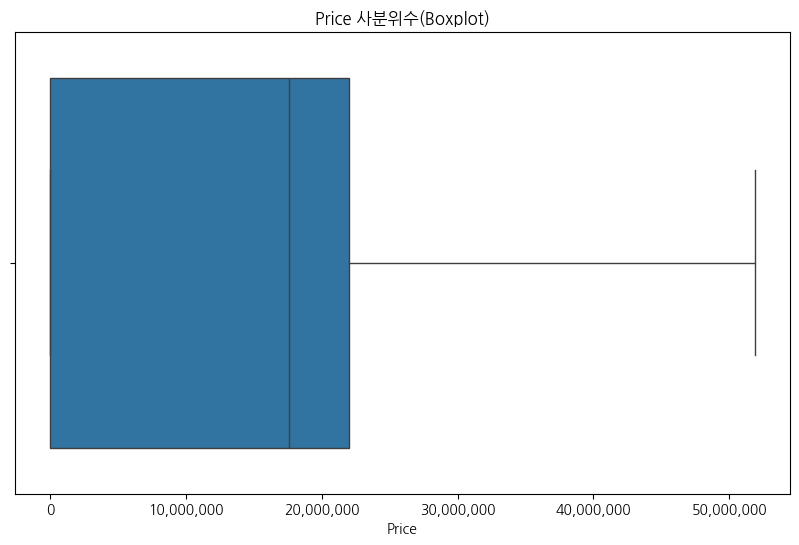

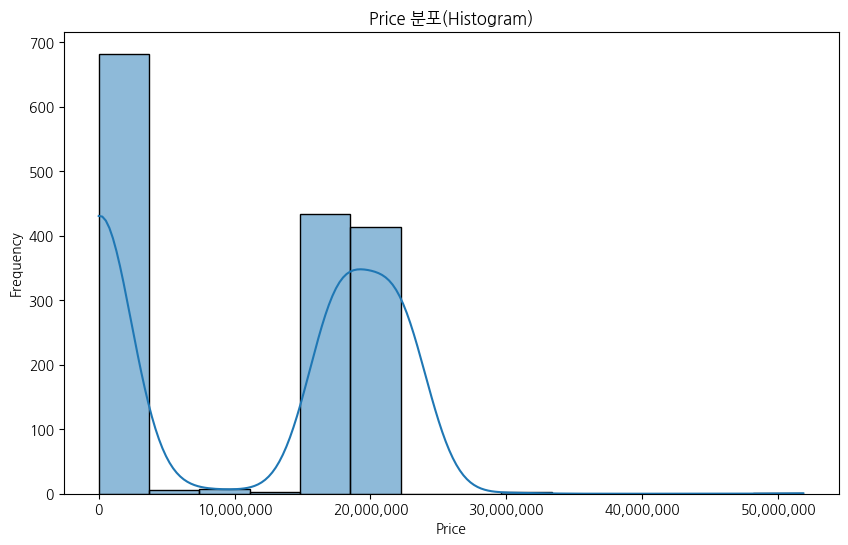

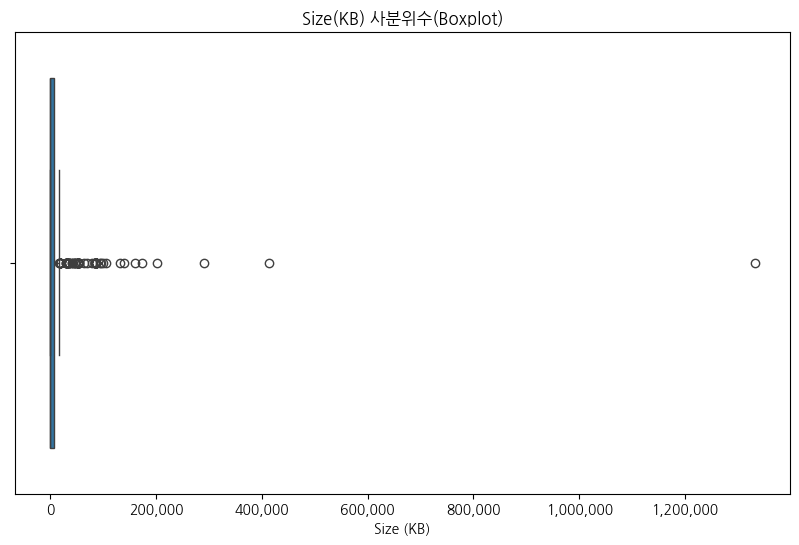

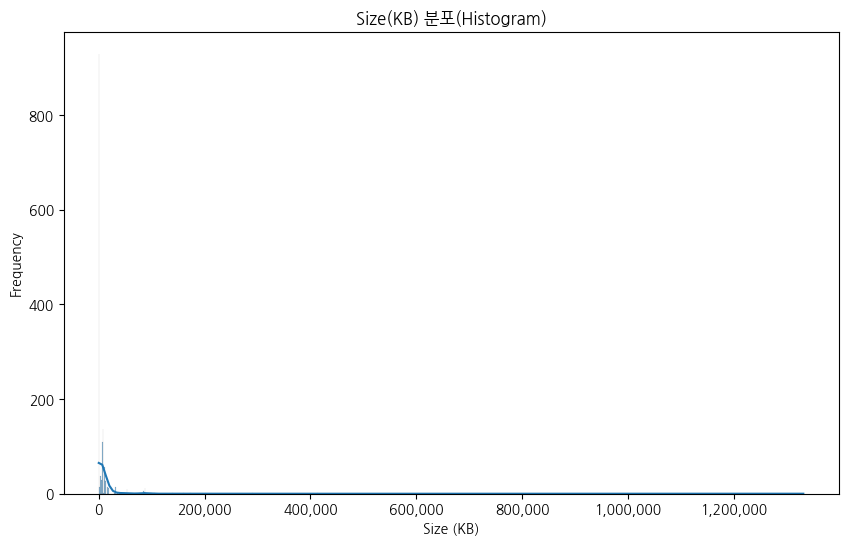

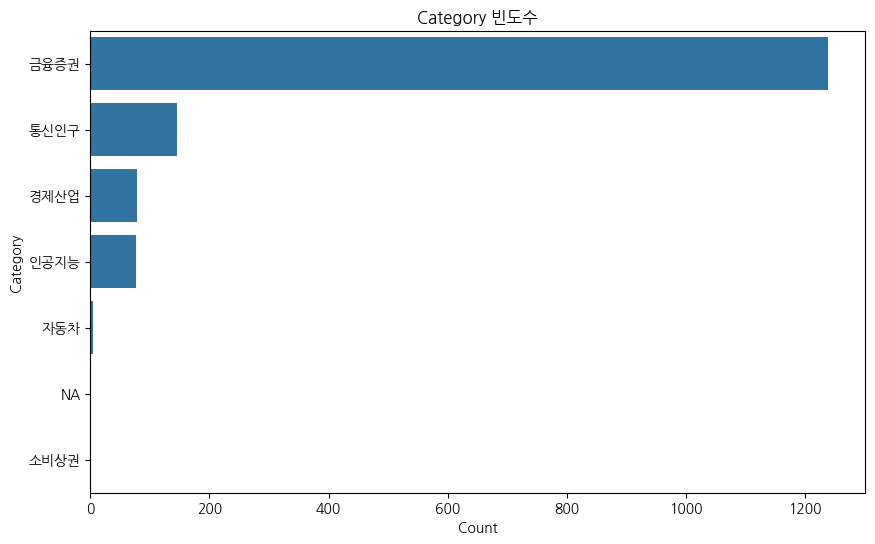

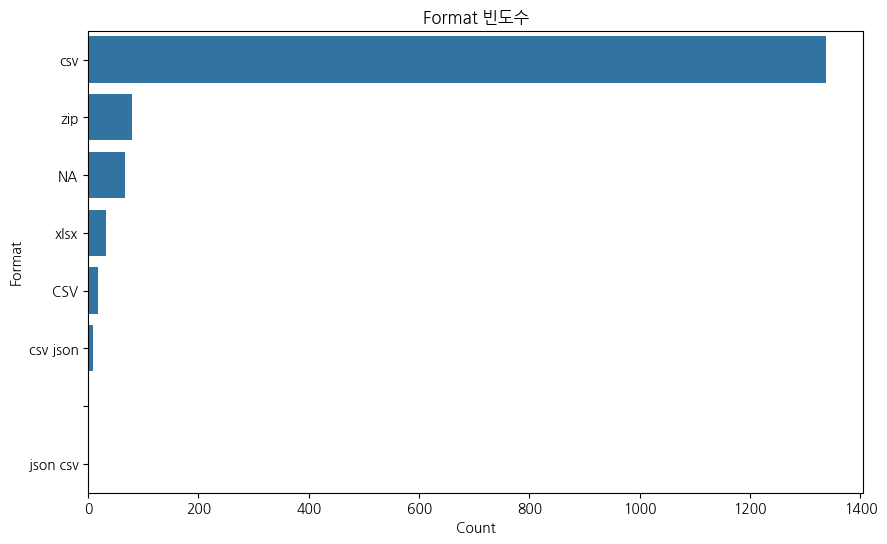

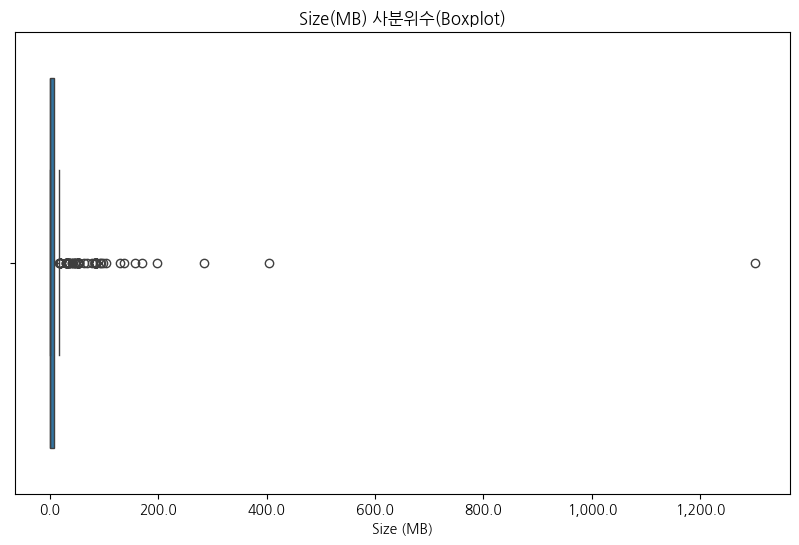

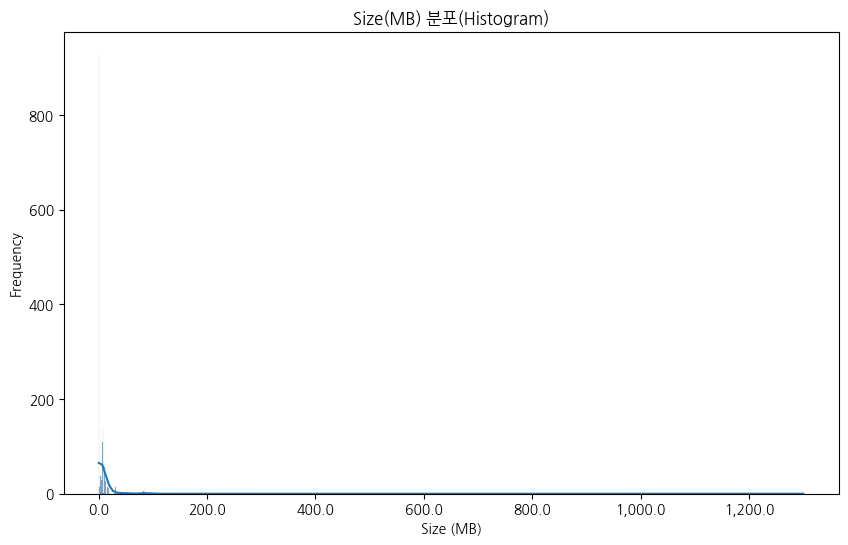

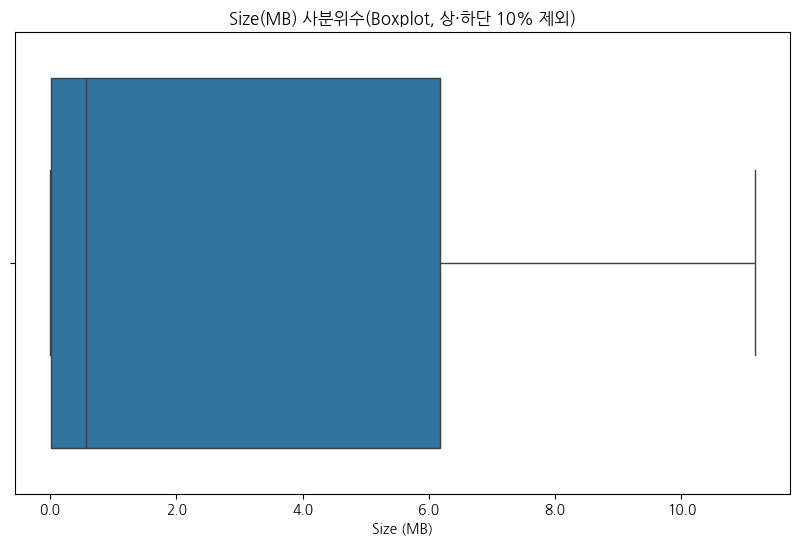


✅ 시각화 완료!


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import json

# ✅ price 숫자 표기 옵션 설정
import matplotlib.ticker as mticker

# ✅ 구글 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

# ✅ JSONL 로드
file_path = '/content/drive/MyDrive/00. 대학원/data-price-20250629-v1.jsonl'

records = []
with open(file_path, 'r', encoding='utf-8') as f:
    for line in f:
        line = line.strip()
        if not line:
            continue
        try:
            json_part = re.search(r'\{.*\}', line)
            if json_part:
                obj = json.loads(json_part.group())
                records.append(obj)
        except json.JSONDecodeError as e:
            print(f"⚠️ JSON 디코드 에러: {e}")
            continue

df = pd.DataFrame(records)

# ✅ 'price' 컬럼 숫자형 변환
df['price'] = pd.to_numeric(df['price'], errors='coerce')

# ✅ 'size' 컬럼 KB 단위로 변환 (개선된 버전)
def convert_size(size_str):
    if isinstance(size_str, str):
        size_str = size_str.strip().upper().replace(",", "")
        # 숫자 추출
        match = re.search(r"[\d.]+", size_str)
        if not match:
            return None
        num = float(match.group())
        if "KB" in size_str:
            return num
        elif "MB" in size_str:
            return num * 1024
        elif "GB" in size_str:
            return num * 1024 * 1024
        elif "B" in size_str:
            return num / 1024
    return None

df['size_kb'] = df['size'].apply(convert_size)

# ✅ 범주형 컬럼 클린업
def clean_category(val):
    if isinstance(val, str):
        val = re.sub(r'[^가-힣a-zA-Z0-9 ]', '', val)
        return val
    return val

df['category'] = df['category'].apply(clean_category)
df['format'] = df['format'].apply(clean_category)

# ✅ 'price' 시각화
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['price'])
plt.title("Price 사분위수(Boxplot)")
plt.gca().xaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))
plt.xlabel("Price")
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(df['price'].dropna(), kde=True)
plt.title("Price 분포(Histogram)")
plt.gca().xaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.show()

# ✅ 'size_kb' 시각화
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['size_kb'])
plt.title("Size(KB) 사분위수(Boxplot)")
plt.gca().xaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))
plt.xlabel("Size (KB)")
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(df['size_kb'].dropna(), kde=True)
plt.title("Size(KB) 분포(Histogram)")
plt.gca().xaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))
plt.xlabel("Size (KB)")
plt.ylabel("Frequency")
plt.show()

# ✅ 'category' 시각화
plt.figure(figsize=(10, 6))
order = df['category'].value_counts().index
sns.countplot(y='category', data=df, order=order)
plt.title("Category 빈도수")
plt.xlabel("Count")
plt.ylabel("Category")
plt.show()

# ✅ 'format' 시각화
plt.figure(figsize=(10, 6))
order = df['format'].value_counts().index
sns.countplot(y='format', data=df, order=order)
plt.title("Format 빈도수")
plt.xlabel("Count")
plt.ylabel("Format")
plt.show()

# 기존 size_kb → size_mb 추가
df['size_mb'] = df['size_kb'] / 1024

# ✅ 'size_mb' 시각화
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['size_mb'])
plt.title("Size(MB) 사분위수(Boxplot)")
plt.gca().xaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.1f}'))
plt.xlabel("Size (MB)")
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(df['size_mb'].dropna(), kde=True)
plt.title("Size(MB) 분포(Histogram)")
plt.gca().xaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.1f}'))
plt.xlabel("Size (MB)")
plt.ylabel("Frequency")
plt.show()

# ✅ 상위/하위 10% 제외한 데이터 필터링
lower = df['size_mb'].quantile(0.10)
upper = df['size_mb'].quantile(0.90)
filtered_df = df[(df['size_mb'] >= lower) & (df['size_mb'] <= upper)]

# ✅ 박스플롯 시각화
plt.figure(figsize=(10, 6))
sns.boxplot(x=filtered_df['size_mb'])
plt.title("Size(MB) 사분위수(Boxplot, 상·하단 10% 제외)")
plt.xlabel("Size (MB)")
plt.gca().xaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.1f}'))
plt.show()


print("\n✅ 시각화 완료!")


# 20250705 - 1차 기능 수정 및 확인 진행
- 판매자 정보 및 데이터 상품 상세 정보를 포함하는 데이터 가치를 판단하는데 도움이되는 자료 추가 수집
- 카테고리, 포맷, 컬럼 등 주요 컬럼의 정규화 => 정규화 사전을 미리 구축 진행
- 데이터셋의 가격이 어떤 요인에 의해서 결정되는지 파악하기 위하여 카테고리별 및 포맷별 가격 분포 확인

In [ ]:
!pip install playwright
!playwright install

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 MB 12.5 MB/s eta 0:00:00
171.6 MiB [] 0% 0.0s171.6 MiB [] 0% 81.7s171.6 MiB [] 0% 86.0s171.6 MiB [] 0% 64.4s171.6 MiB [] 0% 43.8s171.6 MiB [] 0% 30.3s171.6 MiB [] 0% 20.7s171.6 MiB [] 0% 14.2s171.6 MiB [] 1% 9.3s171.6 MiB [] 2% 7.9s171.6 MiB [] 2% 6.6s171.6 MiB [] 3% 5.6s171.6 MiB [] 4% 5.0s171.6 MiB [] 4% 4.7s171.6 MiB [] 4% 4.8s171.6 MiB [] 5% 4.2s171.6 MiB [] 6% 4.0s171.6 MiB [] 7% 3.7s171.6 MiB [] 8% 3.5s171.6 MiB [] 8% 3.3s171.6 MiB [] 9% 3.2s171.6 MiB [] 10% 3.0s171.6 MiB [] 11% 2.8s171.6 MiB [] 12% 2.9s171.6 MiB [] 12% 3.0s171.6 MiB [] 13% 2.9s171.6 MiB [] 14% 2.9s171.6 MiB [] 15% 2.9s171.6 MiB [] 15% 3.0s171.6 MiB [] 16% 2.9s171.6 MiB [] 17% 2.9s171.6 MiB [] 17% 2.8s171.6 MiB [] 18% 2.8s171.6 MiB [] 19% 2.7s171.6 MiB [] 20% 2.6s171.6 MiB [] 21% 2.6s171.6 MiB [] 21% 2.7s171.6 MiB [] 23% 2.6s171.6 MiB [] 23% 2.5s171.6 MiB [] 24% 2.5s171.6 MiB [] 25% 2.4s171.6 MiB [] 26% 2.3s171.6 MiB [] 26% 2.4s171.6 MiB [] 26% 2.5s171.6 MiB [

In [ ]:
import asyncio
import json
import re
from playwright.async_api import async_playwright

start_urls = [
    "https://kdx.kr/data/product-list?specs_id=MA04240002&corp_id=CORP000004&category_id=CA000003"
]

base_url = "https://kdx.kr"

async def run():
    async with async_playwright() as p:
        browser = await p.chromium.launch(headless=True)
        page = await browser.new_page()

        output_file = "output.jsonl"
        with open(output_file, "w", encoding="utf-8") as f:

            for list_idx, start_url in enumerate(start_urls, start=1):
                print(f"\n✅ [리스트 {list_idx}] URL 접근: {start_url}")
                await page.goto(start_url)
                await page.wait_for_timeout(3000)

                all_links = []

                # 페이지네이션 루프
                while True:
                    a_tags = await page.query_selector_all("ul.card-list > a")
                    print(f"상품 링크 개수 (현재 페이지): {len(a_tags)}")

                    for a in a_tags:
                        href = await a.get_attribute("href")
                        if href:
                            full_url = base_url + href
                            all_links.append(full_url)

                    # 다음 페이지 버튼 확인
                    next_button = await page.query_selector("#pagination > a.tui-page-btn.tui-next > span")
                    if next_button:
                        parent_button = await next_button.evaluate_handle("el => el.parentElement")
                        disabled = await parent_button.get_attribute("class")
                        if disabled and "disabled" in disabled:
                            break
                        await parent_button.click()
                        await page.wait_for_timeout(2000)
                    else:
                        break

                print(f"총 수집된 링크 개수: {len(all_links)}")

                for detail_idx, detail_url in enumerate(all_links, start=1):
                    print(f"\n--- [리스트 {list_idx}, 상품 {detail_idx}] 상세 페이지: {detail_url}")
                    await page.goto(detail_url)
                    await page.wait_for_timeout(1500)

                    try:
                        purchase_elem = await page.query_selector("#dataView > div.container > div.detail-wrap > div.item-right > div.purchaseIs > p")
                        purchase_text = await purchase_elem.inner_text()
                        price_num = int(re.sub(r"[^\d]", "", purchase_text))
                    except:
                        price_num = 0

                    try:
                        th_elements = await page.query_selector_all("#dataView > div.container > div.detail-wrap > div.item-left > div.inner > div.table-wrap.preview_wrap > div.sample_data > table > thead > tr > th")
                        schema_columns = [await th.inner_text() for th in th_elements]
                        schema_columns = [col.strip() for col in schema_columns]
                    except:
                        schema_columns = []

                    try:
                        name_elem = await page.query_selector("#dataView > div.container > div.detail-wrap > div.item-left > div.inner > table:nth-child(2) > tbody > tr:nth-child(2) > td")
                        name_text = await name_elem.inner_text()
                    except:
                        name_text = "N/A"

                    try:
                        category_elem = await page.query_selector("#dataView > div.container > div.detail-wrap > div.item-left > div.inner > table:nth-child(2) > tbody > tr:nth-child(1) > td")
                        category_text = await category_elem.inner_text()
                    except:
                        category_text = "N/A"

                    try:
                        format_elem = await page.query_selector("#dataView > div.container > div.detail-wrap > div.item-left > div.inner > table:nth-child(2) > tbody > tr:nth-child(6) > td")
                        format_text = await format_elem.inner_text()
                    except:
                        format_text = "N/A"

                    try:
                        size_elem = await page.query_selector("#dataView > div.container > div.detail-wrap > div.item-left > div.inner > table:nth-child(2) > tbody > tr:nth-child(7) > td")
                        size_text = await size_elem.inner_text()
                    except:
                        size_text = "N/A"

                    # ✅ 상품요약
                    try:
                        summary_elem = await page.query_selector("#dataView > div.container > div.detail-wrap > div.item-left > div.inner > table:nth-child(2) > tbody > tr:nth-child(3) > td")
                        summary_text = await summary_elem.inner_text()
                    except:
                        summary_text = "N/A"

                    # ✅ 상품상세
                    try:
                        detail_elem = await page.query_selector("#dataView > div.container > div.detail-wrap > div.item-left > div.inner > table:nth-child(2) > tbody > tr:nth-child(4) > td")
                        detail_text = await detail_elem.inner_text()
                    except:
                        detail_text = "N/A"

                    # ✅ 판매자
                    try:
                        seller_elem = await page.query_selector("#dataView > div.container > div.detail-wrap > div.item-left > div.inner > table:nth-child(4) > tbody > tr:nth-child(1) > td")
                        seller_text = await seller_elem.inner_text()
                    except:
                        seller_text = "N/A"

                    # ✅ 상품등록일
                    try:
                        reg_elem = await page.query_selector("#dataView > div.container > div.detail-wrap > div.item-right > div.info > div:nth-child(6) > span")
                        reg_text = await reg_elem.inner_text()
                    except:
                        reg_text = "N/A"

                    # ✅ 상품수정일
                    try:
                        mod_elem = await page.query_selector("#dataView > div.container > div.detail-wrap > div.item-right > div.info > div:nth-child(7) > span")
                        mod_text = await mod_elem.inner_text()
                    except:
                        mod_text = "N/A"

                    data = {
                        "columns": schema_columns,
                        "price": price_num,
                        "name": name_text.strip(),
                        "category": category_text.strip(),
                        "format": format_text.strip(),
                        "size": size_text.strip(),
                        "summary": summary_text.strip(),
                        "detail": detail_text.strip(),
                        "seller": seller_text.strip(),
                        "register_date": reg_text.strip(),
                        "modify_date": mod_text.strip(),
                        "url": detail_url
                    }

                    f.write(json.dumps(data, ensure_ascii=False) + "\n")

        await browser.close()
        print(f"\n✅ 전체 리스트 크롤링 및 파일 저장 완료 ➜ {output_file}")

await run()



✅ [리스트 1] URL 접근: https://kdx.kr/data/product-list?specs_id=MA04240002&corp_id=CORP000004&category_id=CA000003
상품 링크 개수 (현재 페이지): 2
총 수집된 링크 개수: 2

--- [리스트 1, 상품 1] 상세 페이지: https://kdx.kr/data/view/41422

--- [리스트 1, 상품 2] 상세 페이지: https://kdx.kr/data/view/41421

✅ 전체 리스트 크롤링 및 파일 저장 완료 ➜ output.jsonl


In [ ]:
import asyncio
import json
import re
from playwright.async_api import async_playwright

start_urls = [
    "https://kdx.kr/data/product-list?specs_id=MA04240002&corp_id=CORP000004&category_id=CA000003"
    # 필요 시 추가
]

base_url = "https://kdx.kr"

async def run():
    async with async_playwright() as p:
        browser = await p.chromium.launch(headless=True)
        page = await browser.new_page()

        output_file = "output.jsonl"
        with open(output_file, "w", encoding="utf-8") as f:

            for list_idx, start_url in enumerate(start_urls, start=1):
                print(f"\n✅ [리스트 {list_idx}] URL 접근: {start_url}")
                await page.goto(start_url)
                await page.wait_for_timeout(3000)

                all_links = []

                # 페이지네이션 루프
                while True:
                    a_tags = await page.query_selector_all("ul.card-list > a")
                    print(f"상품 링크 개수 (현재 페이지): {len(a_tags)}")

                    for a in a_tags:
                        href = await a.get_attribute("href")
                        if href:
                            full_url = base_url + href
                            all_links.append(full_url)

                    # 다음 페이지 버튼 확인
                    next_button = await page.query_selector("#pagination > a.tui-page-btn.tui-next > span")
                    if next_button:
                        parent_button = await next_button.evaluate_handle("el => el.parentElement")
                        disabled = await parent_button.get_attribute("class")
                        if disabled and "disabled" in disabled:
                            break
                        await parent_button.click()
                        await page.wait_for_timeout(2000)
                    else:
                        break

                print(f"총 수집된 링크 개수: {len(all_links)}")

                for detail_idx, detail_url in enumerate(all_links, start=1):
                    print(f"\n--- [리스트 {list_idx}, 상품 {detail_idx}] 상세 페이지: {detail_url}")
                    await page.goto(detail_url)
                    await page.wait_for_timeout(1500)

                    # ✅ 가격 파싱 로직
                    price_num = None
                    min_price = None
                    max_price = None
                    price_type = "고정"

                    try:
                        purchase_elem = await page.query_selector("#dataView > div.container > div.detail-wrap > div.item-right > div.purchaseIs > p")
                        price_text = await purchase_elem.inner_text()

                        if "무료" in price_text:
                            price_num = 0
                            price_type = "무료"
                        elif "협의" in price_text:
                            price_type = "협의"
                        elif "~" in price_text:
                            price_range = re.findall(r"[\d,]+", price_text)
                            if len(price_range) == 2:
                                min_price = int(price_range[0].replace(",", ""))
                                max_price = int(price_range[1].replace(",", ""))
                                price_num = (min_price + max_price) // 2
                                price_type = "범위"
                        else:
                            num_match = re.search(r"[\d,]+", price_text)
                            if num_match:
                                price_num = int(num_match.group(0).replace(",", ""))
                    except:
                        price_num = None
                        price_type = "에러"

                    # ✅ 스키마 컬럼
                    try:
                        th_elements = await page.query_selector_all("#dataView > div.container > div.detail-wrap > div.item-left > div.inner > div.table-wrap.preview_wrap > div.sample_data > table > thead > tr > th")
                        schema_columns = [await th.inner_text() for th in th_elements]
                        schema_columns = [col.strip() for col in schema_columns]
                    except:
                        schema_columns = []

                    try:
                        name_elem = await page.query_selector("#dataView > div.container > div.detail-wrap > div.item-left > div.inner > table:nth-child(2) > tbody > tr:nth-child(2) > td")
                        name_text = await name_elem.inner_text()
                    except:
                        name_text = "N/A"

                    try:
                        category_elem = await page.query_selector("#dataView > div.container > div.detail-wrap > div.item-left > div.inner > table:nth-child(2) > tbody > tr:nth-child(1) > td")
                        category_text = await category_elem.inner_text()
                    except:
                        category_text = "N/A"

                    try:
                        format_elem = await page.query_selector("#dataView > div.container > div.detail-wrap > div.item-left > div.inner > table:nth-child(2) > tbody > tr:nth-child(6) > td")
                        format_text = await format_elem.inner_text()
                    except:
                        format_text = "N/A"

                    try:
                        size_elem = await page.query_selector("#dataView > div.container > div.detail-wrap > div.item-left > div.inner > table:nth-child(2) > tbody > tr:nth-child(7) > td")
                        size_text = await size_elem.inner_text()
                    except:
                        size_text = "N/A"

                    try:
                        summary_elem = await page.query_selector("#dataView > div.container > div.detail-wrap > div.item-left > div.inner > table:nth-child(2) > tbody > tr:nth-child(3) > td")
                        summary_text = await summary_elem.inner_text()
                    except:
                        summary_text = "N/A"

                    try:
                        detail_elem = await page.query_selector("#dataView > div.container > div.detail-wrap > div.item-left > div.inner > table:nth-child(2) > tbody > tr:nth-child(4) > td")
                        detail_text = await detail_elem.inner_text()
                    except:
                        detail_text = "N/A"

                    try:
                        seller_elem = await page.query_selector("#dataView > div.container > div.detail-wrap > div.item-left > div.inner > table:nth-child(4) > tbody > tr:nth-child(1) > td")
                        seller_text = await seller_elem.inner_text()
                    except:
                        seller_text = "N/A"

                    try:
                        reg_elem = await page.query_selector("#dataView > div.container > div.detail-wrap > div.item-right > div.info > div:nth-child(6) > span")
                        reg_text = await reg_elem.inner_text()
                    except:
                        reg_text = "N/A"

                    try:
                        mod_elem = await page.query_selector("#dataView > div.container > div.detail-wrap > div.item-right > div.info > div:nth-child(7) > span")
                        mod_text = await mod_elem.inner_text()
                    except:
                        mod_text = "N/A"

                    data = {
                        "price_num": price_num,
                        "min_price": min_price,
                        "max_price": max_price,
                        "price_type": price_type,
                        "columns": schema_columns,
                        "name": name_text.strip(),
                        "category": category_text.strip(),
                        "format": format_text.strip(),
                        "size": size_text.strip(),
                        "summary": summary_text.strip(),
                        "detail": detail_text.strip(),
                        "seller": seller_text.strip(),
                        "register_date": reg_text.strip(),
                        "modify_date": mod_text.strip(),
                        "url": detail_url
                    }

                    f.write(json.dumps(data, ensure_ascii=False) + "\n")

        await browser.close()
        print(f"\n✅ 전체 리스트 크롤링 및 파일 저장 완료 ➜ {output_file}")

await run()



✅ [리스트 1] URL 접근: https://kdx.kr/data/product-list?specs_id=MA04240002&corp_id=CORP000004&category_id=CA000003
상품 링크 개수 (현재 페이지): 2
총 수집된 링크 개수: 2

--- [리스트 1, 상품 1] 상세 페이지: https://kdx.kr/data/view/41422

--- [리스트 1, 상품 2] 상세 페이지: https://kdx.kr/data/view/41421

✅ 전체 리스트 크롤링 및 파일 저장 완료 ➜ output.jsonl


In [ ]:
import asyncio
import json
import re
from datetime import datetime
from playwright.async_api import async_playwright

start_urls = [
    "https://kdx.kr/data/product-list?specs_id=MA08210022&corp_id=CORP000007&category_id=CA000012",
    "https://kdx.kr/data/product-list?specs_id=MA54230003&corp_id=CORP000047&category_id=CA000001",
    "https://kdx.kr/data/product-list?specs_id=MA54230001&corp_id=CORP000047&category_id=CA000001",
    "https://kdx.kr/data/product-list?specs_id=MA17220002&corp_id=CORP000036&category_id=CA000001%7CCA000002",
    "https://kdx.kr/data/product-list?specs_id=MA17190004&corp_id=CORP000036&category_id=CA000001%7CCA000002",
    "https://kdx.kr/data/product-list?specs_id=MA17200002&corp_id=CORP000036&category_id=CA000002",
    "https://kdx.kr/data/product-list?specs_id=MA55230002&corp_id=CORP000048&category_id=CA000003",
    "https://kdx.kr/data/product-list?specs_id=MA55230001&corp_id=CORP000048&category_id=CA000003",
    "https://kdx.kr/data/product-list?specs_id=MA04240002&corp_id=CORP000004&category_id=CA000003",
    "https://kdx.kr/data/product-list?specs_id=MA56240001&corp_id=CORP000049&category_id=CA000004",
    "https://kdx.kr/data/product-list?specs_id=MA38210002&corp_id=CORP000024&category_id=CA000005",
    "https://kdx.kr/data/product-list?specs_id=MA02190001&corp_id=CORP000002&category_id=CA000004%7CCA000006",
    "https://kdx.kr/data/product-list?specs_id=MA15190001&corp_id=CORP000035&category_id=CA000008",
    "https://kdx.kr/data/product-list?specs_id=MA08210022&corp_id=CORP000007&category_id=CA000012",
    "https://kdx.kr/data/product-list?specs_id=MA58240001&corp_id=CORP000051&category_id=CA000013",
    "https://kdx.kr/data/product-list?specs_id=MA57240002&corp_id=CORP000050&category_id=CA000010",
    "https://kdx.kr/data/product-list?specs_id=MA57240003&corp_id=CORP000050&category_id=CA000010",
    "https://kdx.kr/data/product-list?specs_id=MA57240001&corp_id=CORP000050&category_id=CA000010",
    "https://kdx.kr/data/product-list?specs_id=MA08230002&corp_id=CORP000007&category_id=CA000014%7CCA000015",
    "https://kdx.kr/data/product-list?specs_id=MA15190002&corp_id=CORP000035&category_id=CA000008",
    "https://kdx.kr/data/product-list?specs_id=MA17190001&corp_id=CORP000036&category_id=CA000002",
    "https://kdx.kr/data/product-list?specs_id=MA17190002&corp_id=CORP000036&category_id=CA000002"
]

base_url = "https://kdx.kr"

async def run():
    async with async_playwright() as p:
        browser = await p.chromium.launch(headless=True)
        page = await browser.new_page()

        # 파일명에 시간 정보 추가 - 연월일시분
        now_str = datetime.now().strftime("%Y%m%d%H%M")
        output_file = f"output-{now_str}.jsonl"
        print(f"출력 파일: {output_file}")
        with open(output_file, "w", encoding="utf-8") as f:

            for list_idx, start_url in enumerate(start_urls, start=1):
                print(f"\n✅ [리스트 {list_idx}] URL 접근: {start_url}")
                await page.goto(start_url)
                await page.wait_for_timeout(3000)

                all_links = []

                # 페이지네이션 루프
                while True:
                    a_tags = await page.query_selector_all("ul.card-list > a")
                    print(f"상품 링크 개수 (현재 페이지): {len(a_tags)}")

                    for a in a_tags:
                        href = await a.get_attribute("href")
                        if href:
                            full_url = base_url + href
                            all_links.append(full_url)

                    next_button = await page.query_selector("#pagination > a.tui-page-btn.tui-next > span")
                    if next_button:
                        parent_button = await next_button.evaluate_handle("el => el.parentElement")
                        disabled = await parent_button.get_attribute("class")
                        if disabled and "disabled" in disabled:
                            break
                        await parent_button.click()
                        await page.wait_for_timeout(2000)
                    else:
                        break

                print(f"총 수집된 링크 개수: {len(all_links)}")

                for detail_idx, detail_url in enumerate(all_links, start=1):
                    print(f"\n--- [리스트 {list_idx}, 상품 {detail_idx}] 상세 페이지: {detail_url}")
                    await page.goto(detail_url)
                    await page.wait_for_timeout(1500)

                    # ✅ 가격 처리
                    price_num = None
                    price_type = "고정"

                    try:
                        # 해당 태그는 가격이 1개거나, 무료, 협의의 경우 태그에 해당
                        purchase_elem = await page.query_selector("#dataView > div.container > div.detail-wrap > div.item-right > div.purchaseIs > p")

                        if purchase_elem is None: # 값이 없으면 범위에 해당하는 가격으로 적용
                            purchase_elem = await page.query_selector("#dataView > div.container > div.detail-wrap > div.item-right > div.purchase > p")
                            print("⚠️ 기본 selector에 없음 — 범위 selector 사용")

                        if purchase_elem is None:
                            print("⚠️ 가격 정보 없음 — purchase_elem is None")
                            price_num = None
                            price_type = "에러"
                        else:
                            price_text = await purchase_elem.inner_text()
                            # price_text = re.sub(r"\s+", "", price_text)
                            # print(f">>> price_text 전처리 후: [{price_text}]")

                            if "무료" in price_text:
                                price_num = 0
                                price_type = "무료"
                            elif "협의" in price_text:
                                price_num = 0
                                price_type = "협의"
                            elif "~" in price_text:
                                price_num = price_text
                                price_type = "범위"
                            else:
                                num_match = re.search(r"[\d,]+", price_text)
                                if num_match:
                                    price_num = int(num_match.group(0).replace(",", ""))
                    except Exception as e:
                        print(f"⚠️ 가격 파싱 오류: {e}")
                        price_num = None
                        price_type = "에러"


                    # ✅ 스키마 컬럼
                    try:
                        th_elements = await page.query_selector_all("#dataView > div.container > div.detail-wrap > div.item-left > div.inner > div.table-wrap.preview_wrap > div.sample_data > table > thead > tr > th")
                        schema_columns = [await th.inner_text() for th in th_elements]
                        schema_columns = [col.strip() for col in schema_columns]
                    except:
                        schema_columns = []

                    try:
                        name_elem = await page.query_selector("#dataView > div.container > div.detail-wrap > div.item-left > div.inner > table:nth-child(2) > tbody > tr:nth-child(2) > td")
                        name_text = await name_elem.inner_text()
                    except:
                        name_text = "N/A"

                    try:
                        category_elem = await page.query_selector("#dataView > div.container > div.detail-wrap > div.item-left > div.inner > table:nth-child(2) > tbody > tr:nth-child(1) > td")
                        category_text = await category_elem.inner_text()
                    except:
                        category_text = "N/A"

                    try:
                        format_elem = await page.query_selector("#dataView > div.container > div.detail-wrap > div.item-left > div.inner > table:nth-child(2) > tbody > tr:nth-child(6) > td")
                        format_text = await format_elem.inner_text()
                    except:
                        format_text = "N/A"

                    try:
                        size_elem = await page.query_selector("#dataView > div.container > div.detail-wrap > div.item-left > div.inner > table:nth-child(2) > tbody > tr:nth-child(7) > td")
                        size_text = await size_elem.inner_text()
                    except:
                        size_text = "N/A"

                    try:
                        summary_elem = await page.query_selector("#dataView > div.container > div.detail-wrap > div.item-left > div.inner > table:nth-child(2) > tbody > tr:nth-child(3) > td")
                        summary_text = await summary_elem.inner_text()
                    except:
                        summary_text = "N/A"

                    try:
                        detail_elem = await page.query_selector("#dataView > div.container > div.detail-wrap > div.item-left > div.inner > table:nth-child(2) > tbody > tr:nth-child(4) > td")
                        detail_text = await detail_elem.inner_text()
                    except:
                        detail_text = "N/A"

                    try:
                        seller_elem = await page.query_selector("#dataView > div.container > div.detail-wrap > div.item-left > div.inner > table:nth-child(4) > tbody > tr:nth-child(1) > td")
                        seller_text = await seller_elem.inner_text()
                    except:
                        seller_text = "N/A"

                    try:
                        reg_elem = await page.query_selector("#dataView > div.container > div.detail-wrap > div.item-right > div.info > div:nth-child(6) > span")
                        reg_text = await reg_elem.inner_text()
                    except:
                        reg_text = "N/A"

                    try:
                        mod_elem = await page.query_selector("#dataView > div.container > div.detail-wrap > div.item-right > div.info > div:nth-child(7) > span")
                        mod_text = await mod_elem.inner_text()
                    except:
                        mod_text = "N/A"

                    # ✅ 태그 정보
                    try:
                        tag_elements = await page.query_selector_all(
                            "#dataView > div.container > div.detail-wrap > div.item-right > div.info > div.tag div.tag[data-text]"
                        )
                        tag_list = []
                        for tag in tag_elements:
                            data_text = await tag.get_attribute("data-text")
                            if data_text and data_text.strip():
                                tag_list.append(data_text.strip())
                    except:
                        tag_list = []


                    # ✅ 데이터 딕셔너리
                    data = {
                        "price_num": price_num,
                        "price_type": price_type,
                        "columns": schema_columns,
                        "name": name_text.strip(),
                        "category": category_text.strip(),
                        "format": format_text.strip(),
                        "size": size_text.strip(),
                        "summary": summary_text.strip(),
                        "detail": detail_text.strip(),
                        "seller": seller_text.strip(),
                        "register_date": reg_text.strip(),
                        "modify_date": mod_text.strip(),
                        "tags": tag_list,
                        "url": detail_url
                    }

                    f.write(json.dumps(data, ensure_ascii=False) + "\n")

        await browser.close()
        print(f"\n✅ 전체 리스트 크롤링 및 파일 저장 완료 ➜ {output_file}")

await run()


ERROR:asyncio:Future exception was never retrieved
future: <Future finished exception=TargetClosedError('Target page, context or browser has been closed')>
playwright._impl._errors.TargetClosedError: Target page, context or browser has been closed


출력 파일: output-202507051508.jsonl

✅ [리스트 1] URL 접근: https://kdx.kr/data/product-list?specs_id=MA08210022&corp_id=CORP000007&category_id=CA000012
상품 링크 개수 (현재 페이지): 4
상품 링크 개수 (현재 페이지): 4
상품 링크 개수 (현재 페이지): 4
상품 링크 개수 (현재 페이지): 4
상품 링크 개수 (현재 페이지): 4
상품 링크 개수 (현재 페이지): 4
상품 링크 개수 (현재 페이지): 4
상품 링크 개수 (현재 페이지): 4
상품 링크 개수 (현재 페이지): 4
상품 링크 개수 (현재 페이지): 4
상품 링크 개수 (현재 페이지): 4
상품 링크 개수 (현재 페이지): 4
상품 링크 개수 (현재 페이지): 4
상품 링크 개수 (현재 페이지): 4
상품 링크 개수 (현재 페이지): 4
상품 링크 개수 (현재 페이지): 4
상품 링크 개수 (현재 페이지): 4
상품 링크 개수 (현재 페이지): 4
상품 링크 개수 (현재 페이지): 4
상품 링크 개수 (현재 페이지): 2
총 수집된 링크 개수: 78

--- [리스트 1, 상품 1] 상세 페이지: https://kdx.kr/data/view/41583
⚠️ 기본 selector에 없음 — 범위 selector 사용

--- [리스트 1, 상품 2] 상세 페이지: https://kdx.kr/data/view/41582
⚠️ 기본 selector에 없음 — 범위 selector 사용

--- [리스트 1, 상품 3] 상세 페이지: https://kdx.kr/data/view/41581
⚠️ 기본 selector에 없음 — 범위 selector 사용

--- [리스트 1, 상품 4] 상세 페이지: https://kdx.kr/data/view/41580
⚠️ 기본 selector에 없음 — 범위 selector 사용

--- [리스트 1, 상품 5] 상세 페이지: https://kdx.kr/d

CancelledError: 

In [ ]:
import asyncio
import json
import re
from datetime import datetime
from playwright.async_api import async_playwright

start_urls = [
    "https://kdx.kr/data/product-list?specs_id=MA08210022&corp_id=CORP000007&category_id=CA000012",
    "https://kdx.kr/data/product-list?specs_id=MA54230003&corp_id=CORP000047&category_id=CA000001",
    "https://kdx.kr/data/product-list?specs_id=MA54230001&corp_id=CORP000047&category_id=CA000001",
    "https://kdx.kr/data/product-list?specs_id=MA17220002&corp_id=CORP000036&category_id=CA000001%7CCA000002",
    "https://kdx.kr/data/product-list?specs_id=MA17190004&corp_id=CORP000036&category_id=CA000001%7CCA000002",
    "https://kdx.kr/data/product-list?specs_id=MA17200002&corp_id=CORP000036&category_id=CA000002",
    "https://kdx.kr/data/product-list?specs_id=MA55230002&corp_id=CORP000048&category_id=CA000003",
    "https://kdx.kr/data/product-list?specs_id=MA55230001&corp_id=CORP000048&category_id=CA000003",
    "https://kdx.kr/data/product-list?specs_id=MA04240002&corp_id=CORP000004&category_id=CA000003",
    "https://kdx.kr/data/product-list?specs_id=MA56240001&corp_id=CORP000049&category_id=CA000004",
    "https://kdx.kr/data/product-list?specs_id=MA38210002&corp_id=CORP000024&category_id=CA000005",
    "https://kdx.kr/data/product-list?specs_id=MA02190001&corp_id=CORP000002&category_id=CA000004%7CCA000006",
    "https://kdx.kr/data/product-list?specs_id=MA15190001&corp_id=CORP000035&category_id=CA000008",
    "https://kdx.kr/data/product-list?specs_id=MA08210022&corp_id=CORP000007&category_id=CA000012",
    "https://kdx.kr/data/product-list?specs_id=MA58240001&corp_id=CORP000051&category_id=CA000013",
    "https://kdx.kr/data/product-list?specs_id=MA57240002&corp_id=CORP000050&category_id=CA000010",
    "https://kdx.kr/data/product-list?specs_id=MA57240003&corp_id=CORP000050&category_id=CA000010",
    "https://kdx.kr/data/product-list?specs_id=MA57240001&corp_id=CORP000050&category_id=CA000010",
    "https://kdx.kr/data/product-list?specs_id=MA08230002&corp_id=CORP000007&category_id=CA000014%7CCA000015",
    "https://kdx.kr/data/product-list?specs_id=MA15190002&corp_id=CORP000035&category_id=CA000008",
    "https://kdx.kr/data/product-list?specs_id=MA17190001&corp_id=CORP000036&category_id=CA000002",
    "https://kdx.kr/data/product-list?specs_id=MA17190002&corp_id=CORP000036&category_id=CA000002"
]

base_url = "https://kdx.kr"

async def run():
    async with async_playwright() as p:
        browser = await p.chromium.launch(headless=True)
        page = await browser.new_page()

        # 파일명에 시간 정보 추가 - 연월일시분
        now_str = datetime.now().strftime("%Y%m%d%H%M")
        output_file = f"output-{now_str}.jsonl"
        print(f"출력 파일: {output_file}")
        with open(output_file, "w", encoding="utf-8") as f:

            for list_idx, start_url in enumerate(start_urls, start=1):
                print(f"\n✅ [리스트 {list_idx}] URL 접근: {start_url}")
                await page.goto(start_url)
                await page.wait_for_timeout(3000)

                all_links = []

                # 페이지네이션 루프
                while True:
                    a_tags = await page.query_selector_all("ul.card-list > a")
                    print(f"상품 링크 개수 (현재 페이지): {len(a_tags)}")

                    for a in a_tags:
                        href = await a.get_attribute("href")
                        if href:
                            full_url = base_url + href
                            all_links.append(full_url)

                    next_button = await page.query_selector("#pagination > a.tui-page-btn.tui-next > span")
                    if next_button:
                        parent_button = await next_button.evaluate_handle("el => el.parentElement")
                        disabled = await parent_button.get_attribute("class")
                        if disabled and "disabled" in disabled:
                            break
                        await parent_button.click()
                        await page.wait_for_timeout(2000)
                    else:
                        break

                print(f"총 수집된 링크 개수: {len(all_links)}")

                for detail_idx, detail_url in enumerate(all_links, start=1):
                    print(f"\n--- [리스트 {list_idx}, 상품 {detail_idx}] 상세 페이지: {detail_url}")
                    await page.goto(detail_url)
                    await page.wait_for_timeout(1500)

                    # ✅ 가격 처리
                    price_num = None
                    price_type = "고정"

                    try:
                        # 해당 태그는 가격이 1개거나, 무료, 협의의 경우 태그에 해당
                        # 먼저 purchaseIs selector 기다리기
                        try:
                            await page.wait_for_selector("#dataView > div.container > div.detail-wrap > div.item-right > div.purchaseIs > p", timeout=5000)
                            purchase_elem = await page.query_selector("#dataView > div.container > div.detail-wrap > div.item-right > div.purchaseIs > p")
                        except:
                            # 없으면 purchase selector 기다리기
                            print("⚠️ 기본 selector에 없음 — 범위 selector 사용")
                            try:
                                await page.wait_for_selector("#dataView > div.container > div.detail-wrap > div.item-right > div.purchase > p", timeout=5000)
                                purchase_elem = await page.query_selector("#dataView > div.container > div.detail-wrap > div.item-right > div.purchase > p")
                            except:
                                print("⚠️ 가격 정보 없음 — selector 찾기 실패")
                                purchase_elem = None

                        # 읽어온 구매가격에 대한 객체 정보를 확인
                        if purchase_elem is None:
                            print("⚠️ 가격 정보 없음 — purchase_elem is None")
                            price_num = None
                            price_type = "에러"
                        else:
                            price_text = await purchase_elem.inner_text()
                            # price_text = re.sub(r"\s+", "", price_text)
                            # print(f">>> price_text 전처리 후: [{price_text}]")

                            if "무료" in price_text:
                                price_num = 0
                                price_type = "무료"
                            elif "협의" in price_text:
                                price_num = 0
                                price_type = "협의"
                            elif "~" in price_text:
                                price_num = price_text
                                price_type = "범위"
                            else:
                                num_match = re.search(r"[\d,]+", price_text)
                                if num_match:
                                    price_num = int(num_match.group(0).replace(",", ""))
                    except Exception as e:
                        print(f"⚠️ 가격 파싱 오류: {e}")
                        price_num = None
                        price_type = "에러"


                    # ✅ 스키마 컬럼
                    try:
                        th_elements = await page.query_selector_all("#dataView > div.container > div.detail-wrap > div.item-left > div.inner > div.table-wrap.preview_wrap > div.sample_data > table > thead > tr > th")
                        schema_columns = [await th.inner_text() for th in th_elements]
                        schema_columns = [col.strip() for col in schema_columns]
                    except:
                        schema_columns = []

                    try:
                        name_elem = await page.query_selector("#dataView > div.container > div.detail-wrap > div.item-left > div.inner > table:nth-child(2) > tbody > tr:nth-child(2) > td")
                        name_text = await name_elem.inner_text()
                    except:
                        name_text = "N/A"

                    try:
                        category_elem = await page.query_selector("#dataView > div.container > div.detail-wrap > div.item-left > div.inner > table:nth-child(2) > tbody > tr:nth-child(1) > td")
                        category_text = await category_elem.inner_text()
                    except:
                        category_text = "N/A"

                    try:
                        format_elem = await page.query_selector("#dataView > div.container > div.detail-wrap > div.item-left > div.inner > table:nth-child(2) > tbody > tr:nth-child(6) > td")
                        format_text = await format_elem.inner_text()
                    except:
                        format_text = "N/A"

                    try:
                        size_elem = await page.query_selector("#dataView > div.container > div.detail-wrap > div.item-left > div.inner > table:nth-child(2) > tbody > tr:nth-child(7) > td")
                        size_text = await size_elem.inner_text()
                    except:
                        size_text = "N/A"

                    try:
                        summary_elem = await page.query_selector("#dataView > div.container > div.detail-wrap > div.item-left > div.inner > table:nth-child(2) > tbody > tr:nth-child(3) > td")
                        summary_text = await summary_elem.inner_text()
                    except:
                        summary_text = "N/A"

                    try:
                        detail_elem = await page.query_selector("#dataView > div.container > div.detail-wrap > div.item-left > div.inner > table:nth-child(2) > tbody > tr:nth-child(4) > td")
                        detail_text = await detail_elem.inner_text()
                    except:
                        detail_text = "N/A"

                    try:
                        seller_elem = await page.query_selector("#dataView > div.container > div.detail-wrap > div.item-left > div.inner > table:nth-child(4) > tbody > tr:nth-child(1) > td")
                        seller_text = await seller_elem.inner_text()
                    except:
                        seller_text = "N/A"

                    try:
                        reg_elem = await page.query_selector("#dataView > div.container > div.detail-wrap > div.item-right > div.info > div:nth-child(6) > span")
                        reg_text = await reg_elem.inner_text()
                    except:
                        reg_text = "N/A"

                    try:
                        mod_elem = await page.query_selector("#dataView > div.container > div.detail-wrap > div.item-right > div.info > div:nth-child(7) > span")
                        mod_text = await mod_elem.inner_text()
                    except:
                        mod_text = "N/A"

                    # ✅ 태그 정보
                    try:
                        tag_elements = await page.query_selector_all(
                            "#dataView > div.container > div.detail-wrap > div.item-right > div.info > div.tag div.tag[data-text]"
                        )
                        tag_list = []
                        for tag in tag_elements:
                            data_text = await tag.get_attribute("data-text")
                            if data_text and data_text.strip():
                                tag_list.append(data_text.strip())
                    except:
                        tag_list = []


                    # ✅ 데이터 딕셔너리
                    data = {
                        "price_num": price_num,
                        "price_type": price_type,
                        "columns": schema_columns,
                        "name": name_text.strip(),
                        "category": category_text.strip(),
                        "format": format_text.strip(),
                        "size": size_text.strip(),
                        "summary": summary_text.strip(),
                        "detail": detail_text.strip(),
                        "seller": seller_text.strip(),
                        "register_date": reg_text.strip(),
                        "modify_date": mod_text.strip(),
                        "tags": tag_list,
                        "url": detail_url
                    }

                    f.write(json.dumps(data, ensure_ascii=False) + "\n")

        await browser.close()
        print(f"\n✅ 전체 리스트 크롤링 및 파일 저장 완료 ➜ {output_file}")

await run()


출력 파일: output-202507051526.jsonl

✅ [리스트 1] URL 접근: https://kdx.kr/data/product-list?specs_id=MA08210022&corp_id=CORP000007&category_id=CA000012
상품 링크 개수 (현재 페이지): 4
상품 링크 개수 (현재 페이지): 4
상품 링크 개수 (현재 페이지): 4
상품 링크 개수 (현재 페이지): 4
상품 링크 개수 (현재 페이지): 4
상품 링크 개수 (현재 페이지): 4
상품 링크 개수 (현재 페이지): 4
상품 링크 개수 (현재 페이지): 4
상품 링크 개수 (현재 페이지): 4
상품 링크 개수 (현재 페이지): 4
상품 링크 개수 (현재 페이지): 4
상품 링크 개수 (현재 페이지): 4
상품 링크 개수 (현재 페이지): 4
상품 링크 개수 (현재 페이지): 4
상품 링크 개수 (현재 페이지): 4
상품 링크 개수 (현재 페이지): 4
상품 링크 개수 (현재 페이지): 4
상품 링크 개수 (현재 페이지): 4
상품 링크 개수 (현재 페이지): 4
상품 링크 개수 (현재 페이지): 2
총 수집된 링크 개수: 78

--- [리스트 1, 상품 1] 상세 페이지: https://kdx.kr/data/view/41583
⚠️ 기본 selector에 없음 — 범위 selector 사용

--- [리스트 1, 상품 2] 상세 페이지: https://kdx.kr/data/view/41582
⚠️ 기본 selector에 없음 — 범위 selector 사용

--- [리스트 1, 상품 3] 상세 페이지: https://kdx.kr/data/view/41581
⚠️ 기본 selector에 없음 — 범위 selector 사용

--- [리스트 1, 상품 4] 상세 페이지: https://kdx.kr/data/view/41580
⚠️ 기본 selector에 없음 — 범위 selector 사용

--- [리스트 1, 상품 5] 상세 페이지: https://kdx.kr/d

ERROR:asyncio:Future exception was never retrieved
future: <Future finished exception=TargetClosedError('Target page, context or browser has been closed')>
playwright._impl._errors.TargetClosedError: Target page, context or browser has been closed


⚠️ 기본 selector에 없음 — 범위 selector 사용

--- [리스트 1, 상품 64] 상세 페이지: https://kdx.kr/data/view/41519
⚠️ 기본 selector에 없음 — 범위 selector 사용

--- [리스트 1, 상품 65] 상세 페이지: https://kdx.kr/data/view/41518
⚠️ 기본 selector에 없음 — 범위 selector 사용

--- [리스트 1, 상품 66] 상세 페이지: https://kdx.kr/data/view/41388

--- [리스트 1, 상품 67] 상세 페이지: https://kdx.kr/data/view/41387

--- [리스트 1, 상품 68] 상세 페이지: https://kdx.kr/data/view/41386

--- [리스트 1, 상품 69] 상세 페이지: https://kdx.kr/data/view/41385

--- [리스트 1, 상품 70] 상세 페이지: https://kdx.kr/data/view/41384

--- [리스트 1, 상품 71] 상세 페이지: https://kdx.kr/data/view/41383

--- [리스트 1, 상품 72] 상세 페이지: https://kdx.kr/data/view/41382

--- [리스트 1, 상품 73] 상세 페이지: https://kdx.kr/data/view/41381

--- [리스트 1, 상품 74] 상세 페이지: https://kdx.kr/data/view/41380

--- [리스트 1, 상품 75] 상세 페이지: https://kdx.kr/data/view/41379

--- [리스트 1, 상품 76] 상세 페이지: https://kdx.kr/data/view/41378

--- [리스트 1, 상품 77] 상세 페이지: https://kdx.kr/data/view/41295

--- [리스트 1, 상품 78] 상세 페이지: https://kdx.kr/data/view/28687
⚠️ 기본 s

# 20250706 - 2차 기능 수정

In [ ]:
# ✅ 코랩 환경에서 필요한 패키지 설치
!pip install playwright nest_asyncio

# ✅ Playwright 초기화 (처음 한 번만 실행하면 됨)
!playwright install

In [ ]:
import nest_asyncio
import asyncio
import json
import re
from datetime import datetime
from playwright.async_api import async_playwright

# ✅ 중첩된 이벤트 루프 허용
nest_asyncio.apply()

start_urls = [
    "https://kdx.kr/data/product-list?specs_id=MA54230002&corp_id=CORP000047&category_id=CA000001",
    "https://kdx.kr/data/product-list?specs_id=MA54240001&corp_id=CORP000047&category_id=CA000001",
    "https://kdx.kr/data/product-list?specs_id=MA19220003&corp_id=CORP000016&category_id=CA000001",
    "https://kdx.kr/data/product-list?specs_id=MA19230001&corp_id=CORP000016&category_id=CA000001",
    "https://kdx.kr/data/product-list?specs_id=MA19230002&corp_id=CORP000016&category_id=CA000001",
    "https://kdx.kr/data/product-list?specs_id=MA36210003&corp_id=CORP000030&category_id=CA000014",
    "https://kdx.kr/data/product-list?specs_id=MA17200004&corp_id=CORP000036&category_id=CA000002",
    "https://kdx.kr/data/product-list?specs_id=MA17200003&corp_id=CORP000036&category_id=CA000002",
    "https://kdx.kr/data/product-list?specs_id=MA17200002&corp_id=CORP000036&category_id=CA000002",
    "https://kdx.kr/data/product-list?specs_id=MA17200001&corp_id=CORP000036&category_id=CA000002",
    "https://kdx.kr/data/product-list?specs_id=MA17190001&corp_id=CORP000036&category_id=CA000002",
    "https://kdx.kr/data/product-list?specs_id=MA17190002&corp_id=CORP000036&category_id=CA000002",
    "https://kdx.kr/data/product-list?specs_id=MA17190003&corp_id=CORP000036&category_id=CA000002",
    "https://kdx.kr/data/product-list?specs_id=MA17190004&corp_id=CORP000036&category_id=CA000001%7CCA000002",
    "https://kdx.kr/data/product-list?specs_id=MA17220002&corp_id=CORP000036&category_id=CA000001%7CCA000002",
    "https://kdx.kr/data/product-list?specs_id=MA19230001&corp_id=CORP000016&category_id=CA000001",
    "https://kdx.kr/data/product-list?specs_id=MA17210001&corp_id=CORP000036&category_id=CA000002",
    "https://kdx.kr/data/product-list?specs_id=MA04240002&corp_id=CORP000004&category_id=CA000003",
    "https://kdx.kr/data/product-list?specs_id=MA55230002&corp_id=CORP000048&category_id=CA000003",
    "https://kdx.kr/data/product-list?specs_id=MA55230001&corp_id=CORP000048&category_id=CA000003",
    "https://kdx.kr/data/product-list?specs_id=MA55230001&corp_id=CORP000048&category_id=CA000003",
    "https://kdx.kr/data/product-list?specs_id=MA55240002&corp_id=CORP000048&category_id=CA000003",
    "https://kdx.kr/data/product-list?specs_id=MA36220001&corp_id=CORP000030&category_id=CA000003",
    "https://kdx.kr/data/product-list?specs_id=MA36210001&corp_id=CORP000030&category_id=CA000003",
    "https://kdx.kr/data/product-list?specs_id=MA36220003&corp_id=CORP000030&category_id=CA000003",
    "https://kdx.kr/data/product-list?specs_id=MA36220003&corp_id=CORP000030&category_id=CA000003",
    "https://kdx.kr/data/product-list?specs_id=MA17220002&corp_id=CORP000036&category_id=CA000001%7CCA000002",
    "https://kdx.kr/data/product-list?specs_id=MA56240001&corp_id=CORP000049&category_id=CA000004",
    "https://kdx.kr/data/product-list?specs_id=MA19230002&corp_id=CORP000016&category_id=CA000001",
    "https://kdx.kr/data/product-list?specs_id=MA02190002&corp_id=CORP000002&category_id=CA000004",
    "https://kdx.kr/data/product-list?specs_id=MA02190001&corp_id=CORP000002&category_id=CA000004%7CCA000006",
    "https://kdx.kr/data/product-list?specs_id=MA02200004&corp_id=CORP000002&category_id=CA000004",
    "https://kdx.kr/data/product-list?specs_id=MA36210001&corp_id=CORP000030&category_id=CA000003",
    "https://kdx.kr/data/product-list?specs_id=MA12200001&corp_id=CORP000011&category_id=CA000006",
    "https://kdx.kr/data/product-list?specs_id=MA05200001&corp_id=CORP000005&category_id=CA000004",
    "https://kdx.kr/data/product-list?specs_id=MA05200003&corp_id=CORP000005&category_id=CA000004",
    "https://kdx.kr/data/product-list?specs_id=MA05190011&corp_id=CORP000005&category_id=CA000004",
    "https://kdx.kr/data/product-list?specs_id=MA05190007&corp_id=CORP000005&category_id=CA000004",
    "https://kdx.kr/data/product-list?specs_id=MA05190004&corp_id=CORP000005&category_id=CA000004",
    "https://kdx.kr/data/product-list?specs_id=MA05190002&corp_id=CORP000005&category_id=CA000004",
    "https://kdx.kr/data/product-list?specs_id=MA05200004&corp_id=CORP000005&category_id=CA000004",
    "https://kdx.kr/data/product-list?specs_id=MA05200006&corp_id=CORP000005&category_id=CA000004",
    "https://kdx.kr/data/product-list?specs_id=MA05200005&corp_id=CORP000005&category_id=CA000004",
    "https://kdx.kr/data/product-list?specs_id=MA12190001&corp_id=CORP000011&category_id=CA000006",
    "https://kdx.kr/data/product-list?specs_id=MA12190002&corp_id=CORP000011&category_id=CA000006",
    "https://kdx.kr/data/product-list?specs_id=MA17200005&corp_id=CORP000036&category_id=CA000004",
    "https://kdx.kr/data/product-list?specs_id=MA38210002&corp_id=CORP000024&category_id=CA000005",
    "https://kdx.kr/data/product-list?specs_id=MA15190002&corp_id=CORP000035&category_id=CA000008",
    "https://kdx.kr/data/product-list?specs_id=MA02190001&corp_id=CORP000002&category_id=CA000004%7CCA000006",
    "https://kdx.kr/data/product-list?specs_id=MA36210001&corp_id=CORP000030&category_id=CA000003",
    "https://kdx.kr/data/product-list?specs_id=MA15210002&corp_id=CORP000035&category_id=CA000006",
    "https://kdx.kr/data/product-list?specs_id=MA12200001&corp_id=CORP000011&category_id=CA000006",
    "https://kdx.kr/data/product-list?specs_id=MA12190001&corp_id=CORP000011&category_id=CA000006",
    "https://kdx.kr/data/product-list?specs_id=MA12190002&corp_id=CORP000011&category_id=CA000006",
    "https://kdx.kr/data/product-list?specs_id=MA15190001&corp_id=CORP000035&category_id=CA000008",
    "https://kdx.kr/data/product-list?specs_id=MA15190003&corp_id=CORP000035&category_id=CA000008",
    "https://kdx.kr/data/product-list?specs_id=MA15190002&corp_id=CORP000035&category_id=CA000008",
    "https://kdx.kr/data/product-list?specs_id=MA15210004&corp_id=CORP000035&category_id=CA000008",
    "https://kdx.kr/data/product-list?specs_id=MA15200001&corp_id=CORP000035&category_id=CA000008",
    "https://kdx.kr/data/product-list?specs_id=MA57240002&corp_id=CORP000050&category_id=CA000010",
    "https://kdx.kr/data/product-list?specs_id=MA57240003&corp_id=CORP000050&category_id=CA000010",
    "https://kdx.kr/data/product-list?specs_id=MA57240001&corp_id=CORP000050&category_id=CA000010",
    "https://kdx.kr/data/product-list?specs_id=MA11200008&corp_id=CORP000010&category_id=CA000014",
    "https://kdx.kr/data/product-list?specs_id=MA11200008&corp_id=CORP000010&category_id=CA000014",
    "https://kdx.kr/data/product-list?specs_id=MA08210022&corp_id=CORP000007&category_id=CA000012",
    "https://kdx.kr/data/product-list?specs_id=MA58240001&corp_id=CORP000051&category_id=CA000013",
    "https://kdx.kr/data/product-list?specs_id=MA08230002&corp_id=CORP000007&category_id=CA000014%7CCA000015",
    "https://kdx.kr/data/product-list?specs_id=MA36210003&corp_id=CORP000030&category_id=CA000014",
    "https://kdx.kr/data/product-list?specs_id=MA36210002&corp_id=CORP000030&category_id=CA000014",
    "https://kdx.kr/data/product-list?specs_id=MA11210001&corp_id=CORP000010&category_id=CA000014",
    "https://kdx.kr/data/product-list?specs_id=MA11210002&corp_id=CORP000010&category_id=CA000014",
    "https://kdx.kr/data/product-list?specs_id=MA54230003&corp_id=CORP000047&category_id=CA000001",
    "https://kdx.kr/data/product-list?specs_id=MA54230001&corp_id=CORP000047&category_id=CA000001",
    "https://kdx.kr/data/product-list?specs_id=MA19220002&corp_id=CORP000016&category_id=CA000001",
    "https://kdx.kr/data/product-list?specs_id=MA17220002&corp_id=CORP000036&category_id=CA000001%7CCA000002",
    "https://kdx.kr/data/product-list?specs_id=MA17190004&corp_id=CORP000036&category_id=CA000001%7CCA000002",
    "https://kdx.kr/data/product-list?specs_id=MA08210028&corp_id=CORP000007&category_id=CA000015",
]

base_url = "https://kdx.kr"

async def run():
    async with async_playwright() as p:
        browser = await p.chromium.launch(headless=True)
        page = await browser.new_page()

        now_str = datetime.now().strftime("%Y%m%d%H%M")
        output_file = f"output-{now_str}.jsonl"
        print(f"출력 파일: {output_file}")

        with open(output_file, "w", encoding="utf-8") as f:
            for list_idx, start_url in enumerate(start_urls, start=1):
                print(f"\n✅ [리스트 {list_idx}] URL 접근: {start_url}")
                await page.goto(start_url)
                await page.wait_for_timeout(3000)

                all_links = []
                while True:
                    a_tags = await page.query_selector_all("ul.card-list > a")
                    print(f"상품 링크 개수 (현재 페이지): {len(a_tags)}")

                    for a in a_tags:
                        href = await a.get_attribute("href")
                        if href:
                            full_url = base_url + href
                            all_links.append(full_url)

                    next_button = await page.query_selector("#pagination > a.tui-page-btn.tui-next > span")
                    if next_button:
                        parent_button = await next_button.evaluate_handle("el => el.parentElement")
                        disabled = await parent_button.get_attribute("class")
                        if disabled and "disabled" in disabled:
                            break
                        await parent_button.click()
                        await page.wait_for_timeout(2000)
                    else:
                        break

                print(f"총 수집된 링크 개수: {len(all_links)}")

                for detail_idx, detail_url in enumerate(all_links, start=1):
                    print(f"\n--- [리스트 {list_idx}, 상품 {detail_idx}] 상세 페이지: {detail_url}")
                    await page.goto(detail_url)
                    await page.wait_for_timeout(1500)

                    # ✅ 가격 처리
                    price_num = None
                    price_type = "고정"

                    try:
                        price_text = None

                        # 첫 번째 시도: 무료 또는 협의
                        try:
                            await page.wait_for_selector("#dataView > div.container > div.detail-wrap > div.item-right > div.purchaseIs > h4 > p", timeout=3000)
                            purchase_elem = await page.query_selector("#dataView > div.container > div.detail-wrap > div.item-right > div.purchaseIs > h4 > p")
                            price_text = await purchase_elem.inner_text()

                            if "무료" in price_text:
                                price_num = 0
                                price_type = "무료"
                                print("✔️ 무료 유형 탐지")
                            elif "협의" in price_text:
                                price_num = 0
                                price_type = "협의"
                                print("✔️ 협의 유형 탐지")
                        except:
                            pass

                        # 두 번째 시도: 범위
                        if price_text is None:
                            try:
                                await page.wait_for_selector("#dataView > div.container > div.detail-wrap > div.item-right > div.purchase > p", timeout=3000)
                                purchase_elem = await page.query_selector("#dataView > div.container > div.detail-wrap > div.item-right > div.purchase > p")
                                price_text = await purchase_elem.inner_text()
                                price_num = price_text
                                price_type = "범위"
                                print("✔️ 범위 유형 탐지")
                            except:
                                pass

                        # 세 번째 시도: 고정
                        if price_text is None:
                            try:
                                await page.wait_for_selector("#dataView > div.container > div.detail-wrap > div.item-right > div.purchaseIs > p", timeout=3000)
                                purchase_elem = await page.query_selector("#dataView > div.container > div.detail-wrap > div.item-right > div.purchaseIs > p")
                                price_text = await purchase_elem.inner_text()
                                num_match = re.search(r"[\d,]+", price_text)
                                if num_match:
                                    price_num = int(num_match.group(0).replace(",", ""))
                                price_type = "고정"
                                print("✔️ 고정 유형 탐지")
                            except:
                                pass

                        if price_text is None:
                            print("⚠️ 가격 정보 없음")
                            price_num = None
                            price_type = "에러"

                    except Exception as e:
                        print(f"⚠️ 가격 파싱 오류: {e}")
                        price_num = None
                        price_type = "에러"

                    # ✅ 스키마 컬럼
                    try:
                        th_elements = await page.query_selector_all("#dataView > div.container > div.detail-wrap > div.item-left > div.inner > div.table-wrap.preview_wrap > div.sample_data > table > thead > tr > th")
                        schema_columns = [await th.inner_text() for th in th_elements]
                        schema_columns = [col.strip() for col in schema_columns]
                    except:
                        schema_columns = []

                    # ✅ 기타 정보
                    async def safe_text(selector, default="N/A"):
                        try:
                            elem = await page.query_selector(selector)
                            return (await elem.inner_text()).strip() if elem else default
                        except:
                            return default

                    name_text = await safe_text("#dataView > div.container > div.detail-wrap > div.item-left > div.inner > table:nth-child(2) > tbody > tr:nth-child(2) > td")
                    category_text = await safe_text("#dataView > div.container > div.detail-wrap > div.item-left > div.inner > table:nth-child(2) > tbody > tr:nth-child(1) > td")
                    format_text = await safe_text("#dataView > div.container > div.detail-wrap > div.item-left > div.inner > table:nth-child(2) > tbody > tr:nth-child(6) > td")
                    size_text = await safe_text("#dataView > div.container > div.detail-wrap > div.item-left > div.inner > table:nth-child(2) > tbody > tr:nth-child(7) > td")
                    summary_text = await safe_text("#dataView > div.container > div.detail-wrap > div.item-left > div.inner > table:nth-child(2) > tbody > tr:nth-child(3) > td")
                    detail_text = await safe_text("#dataView > div.container > div.detail-wrap > div.item-left > div.inner > table:nth-child(2) > tbody > tr:nth-child(4) > td")
                    seller_text = await safe_text("#dataView > div.container > div.detail-wrap > div.item-left > div.inner > table:nth-child(4) > tbody > tr:nth-child(1) > td")
                    reg_text = await safe_text("#dataView > div.container > div.detail-wrap > div.item-right > div.info > div:nth-child(6) > span")
                    mod_text = await safe_text("#dataView > div.container > div.detail-wrap > div.item-right > div.info > div:nth-child(7) > span")

                    # ✅ 태그 정보
                    try:
                        tag_elements = await page.query_selector_all("#dataView > div.container > div.detail-wrap > div.item-right > div.info > div.tag div.tag[data-text]")
                        tag_list = []
                        for tag in tag_elements:
                            data_text = await tag.get_attribute("data-text")
                            if data_text and data_text.strip():
                                tag_list.append(data_text.strip())
                    except:
                        tag_list = []

                    data = {
                        "price_num": price_num,
                        "price_type": price_type,
                        "columns": schema_columns,
                        "name": name_text,
                        "category": category_text,
                        "format": format_text,
                        "size": size_text,
                        "summary": summary_text,
                        "detail": detail_text,
                        "seller": seller_text,
                        "register_date": reg_text,
                        "modify_date": mod_text,
                        "tags": tag_list,
                        "url": detail_url
                    }

                    f.write(json.dumps(data, ensure_ascii=False) + "\n")

        await browser.close()
        print(f"\n✅ 전체 리스트 크롤링 및 파일 저장 완료 ➜ {output_file}")

# ✅ 코랩에서는 아래처럼 실행
await run()




출력 파일: output-202507060045.jsonl

✅ [리스트 1] URL 접근: https://kdx.kr/data/product-list?specs_id=MA54230002&corp_id=CORP000047&category_id=CA000001
상품 링크 개수 (현재 페이지): 4
상품 링크 개수 (현재 페이지): 4
상품 링크 개수 (현재 페이지): 4
상품 링크 개수 (현재 페이지): 4
상품 링크 개수 (현재 페이지): 4
상품 링크 개수 (현재 페이지): 4
상품 링크 개수 (현재 페이지): 4
상품 링크 개수 (현재 페이지): 1
총 수집된 링크 개수: 29

--- [리스트 1, 상품 1] 상세 페이지: https://kdx.kr/data/view/40657
✔️ 무료 유형 탐지

--- [리스트 1, 상품 2] 상세 페이지: https://kdx.kr/data/view/40656
✔️ 고정 유형 탐지

--- [리스트 1, 상품 3] 상세 페이지: https://kdx.kr/data/view/37242
✔️ 무료 유형 탐지

--- [리스트 1, 상품 4] 상세 페이지: https://kdx.kr/data/view/37237
✔️ 무료 유형 탐지

--- [리스트 1, 상품 5] 상세 페이지: https://kdx.kr/data/view/37232
✔️ 협의 유형 탐지

--- [리스트 1, 상품 6] 상세 페이지: https://kdx.kr/data/view/37229
✔️ 무료 유형 탐지

--- [리스트 1, 상품 7] 상세 페이지: https://kdx.kr/data/view/37228
✔️ 고정 유형 탐지

--- [리스트 1, 상품 8] 상세 페이지: https://kdx.kr/data/view/37218
✔️ 무료 유형 탐지

--- [리스트 1, 상품 9] 상세 페이지: https://kdx.kr/data/view/37217
✔️ 고정 유형 탐지

--- [리스트 1, 상품 10] 상세 페이지: https://kdx.k

ERROR:asyncio:Future exception was never retrieved
future: <Future finished exception=TargetClosedError('Target page, context or browser has been closed')>
playwright._impl._errors.TargetClosedError: Target page, context or browser has been closed


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
--- [리스트 13, 상품 94] 상세 페이지: https://kdx.kr/data/view/35500
✔️ 고정 유형 탐지

--- [리스트 13, 상품 95] 상세 페이지: https://kdx.kr/data/view/35499
✔️ 고정 유형 탐지

--- [리스트 13, 상품 96] 상세 페이지: https://kdx.kr/data/view/35498
✔️ 무료 유형 탐지

--- [리스트 13, 상품 97] 상세 페이지: https://kdx.kr/data/view/35095
✔️ 고정 유형 탐지

--- [리스트 13, 상품 98] 상세 페이지: https://kdx.kr/data/view/35094
✔️ 고정 유형 탐지

--- [리스트 13, 상품 99] 상세 페이지: https://kdx.kr/data/view/35093
✔️ 무료 유형 탐지

--- [리스트 13, 상품 100] 상세 페이지: https://kdx.kr/data/view/34746
✔️ 고정 유형 탐지

--- [리스트 13, 상품 101] 상세 페이지: https://kdx.kr/data/view/34745
✔️ 고정 유형 탐지

--- [리스트 13, 상품 102] 상세 페이지: https://kdx.kr/data/view/34744
✔️ 무료 유형 탐지

--- [리스트 13, 상품 103] 상세 페이지: https://kdx.kr/data/view/34343
✔️ 고정 유형 탐지

--- [리스트 13, 상품 104] 상세 페이지: https://kdx.kr/data/view/34342
✔️ 고정 유형 탐지

--- [리스트 13, 상품 105] 상세 페이지: https://kdx.kr/data/view/34341
✔️ 무료 유형 탐지

--- [리스트 13, 상품 106] 상세 페이지: https://kdx.kr/data/view/33948
✔️ 고정 유형 탐지

--- [리스트 13, 상품 107] 

# 20250706 - 데이터 시각화 수행

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


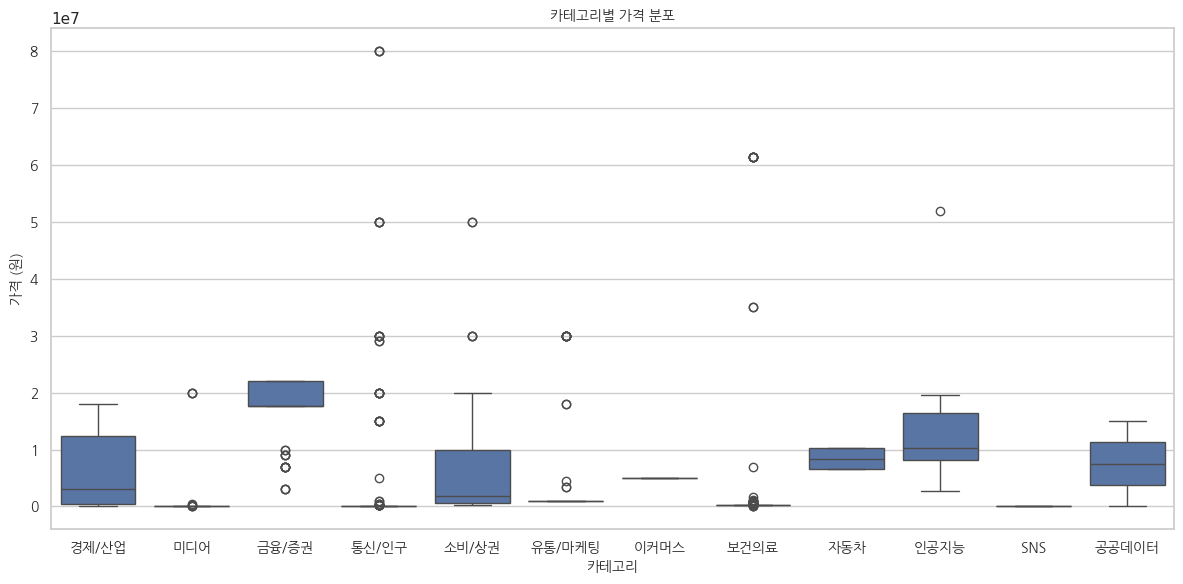

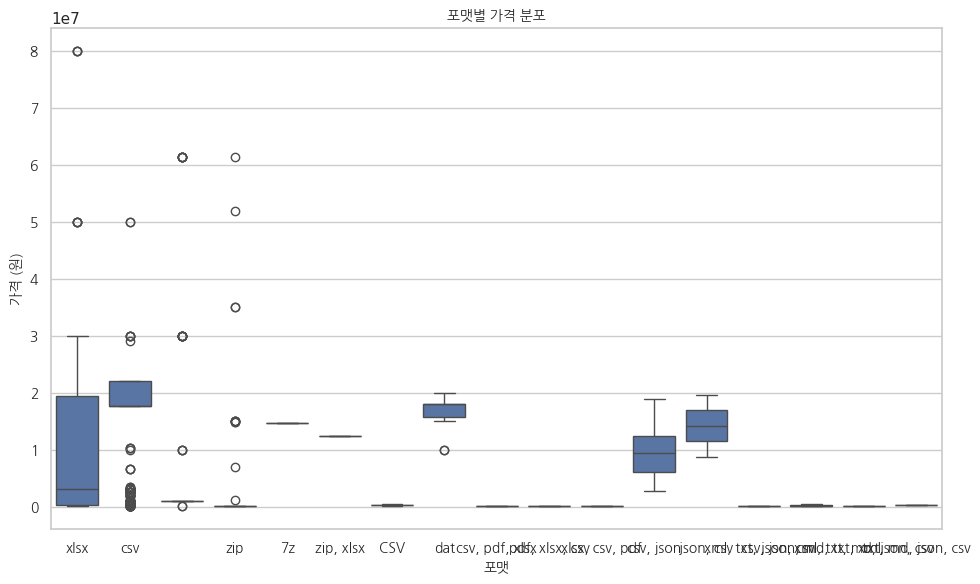

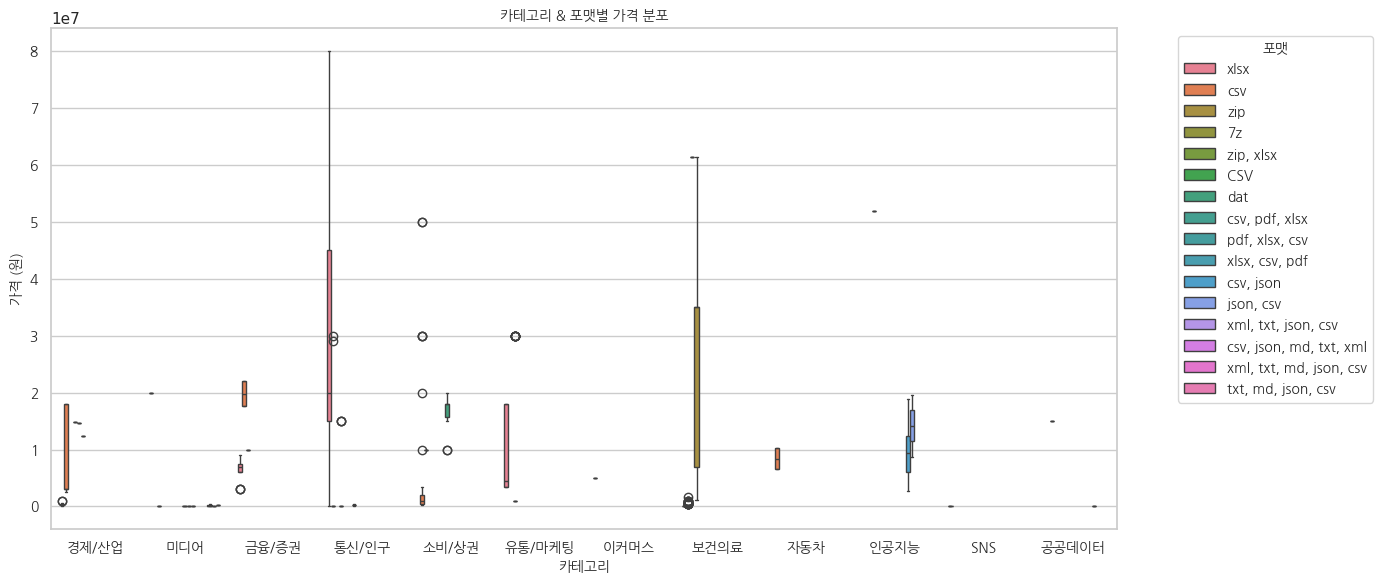

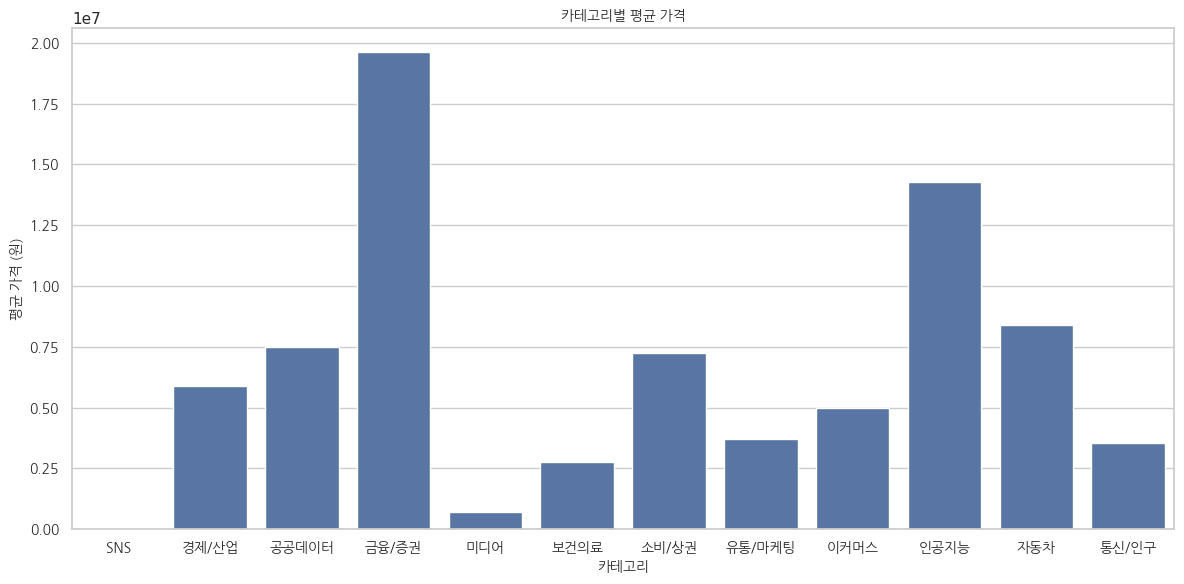

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import json

# ✅ 한글 폰트 개별 지정 객체 생성
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
prop = fm.FontProperties(fname=font_path)

# ✅ 구글 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

# ✅ JSONL 파일 경로
file_path = '/content/drive/MyDrive/00. 대학원/data-price-20250706-v2.jsonl'

# ✅ JSONL 파일 읽기
records = []
with open(file_path, 'r', encoding='utf-8') as f:
    for line in f:
        line = line.strip()
        if line:
            records.append(json.loads(line))

# ✅ DataFrame 변환
df = pd.DataFrame(records)

# ✅ price_num을 숫자로 변환 (문자열 등 오류 시 NaN)
df['price_num'] = pd.to_numeric(df['price_num'], errors='coerce')

# ✅ NaN 제외
df = df.dropna(subset=['price_num'])

# ✅ 가격이 0이거나 협의인 경우는 제외 (선택)
df_filtered = df[(df['price_num'] > 0) & (df['price_type'] == '고정')]

# ✅ seaborn 스타일 설정
sns.set(style="whitegrid")

# ✅ 카테고리별 가격 분포 boxplot
plt.figure(figsize=(12, 6))
ax1 = sns.boxplot(x='category', y='price_num', data=df_filtered)
ax1.set_title('카테고리별 가격 분포', fontproperties=prop)
ax1.set_ylabel('가격 (원)', fontproperties=prop)
ax1.set_xlabel('카테고리', fontproperties=prop)
for label in ax1.get_xticklabels():
    label.set_fontproperties(prop)
for label in ax1.get_yticklabels():
    label.set_fontproperties(prop)
plt.tight_layout()
plt.show()

# ✅ 포맷별 가격 분포 boxplot
plt.figure(figsize=(10, 6))
ax2 = sns.boxplot(x='format', y='price_num', data=df_filtered)
ax2.set_title('포맷별 가격 분포', fontproperties=prop)
ax2.set_ylabel('가격 (원)', fontproperties=prop)
ax2.set_xlabel('포맷', fontproperties=prop)
for label in ax2.get_xticklabels():
    label.set_fontproperties(prop)
for label in ax2.get_yticklabels():
    label.set_fontproperties(prop)
plt.tight_layout()
plt.show()

# ✅ 카테고리 & 포맷 조합별 가격 분포 boxplot
plt.figure(figsize=(14, 6))
ax3 = sns.boxplot(x='category', y='price_num', hue='format', data=df_filtered)
ax3.set_title('카테고리 & 포맷별 가격 분포', fontproperties=prop)
ax3.set_ylabel('가격 (원)', fontproperties=prop)
ax3.set_xlabel('카테고리', fontproperties=prop)
for label in ax3.get_xticklabels():
    label.set_fontproperties(prop)
for label in ax3.get_yticklabels():
    label.set_fontproperties(prop)
leg = ax3.legend(title='포맷', bbox_to_anchor=(1.05, 1), loc='upper left')
leg.set_title('포맷', prop=prop)
for text in leg.get_texts():
    text.set_fontproperties(prop)
plt.tight_layout()
plt.show()

# ✅ 카테고리별 평균 가격 barplot (참고용)
plt.figure(figsize=(12, 6))
avg_prices = df_filtered.groupby('category')['price_num'].mean().reset_index()
ax4 = sns.barplot(x='category', y='price_num', data=avg_prices)
ax4.set_title('카테고리별 평균 가격', fontproperties=prop)
ax4.set_ylabel('평균 가격 (원)', fontproperties=prop)
ax4.set_xlabel('카테고리', fontproperties=prop)
for label in ax4.get_xticklabels():
    label.set_fontproperties(prop)
for label in ax4.get_yticklabels():
    label.set_fontproperties(prop)
plt.tight_layout()
plt.show()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


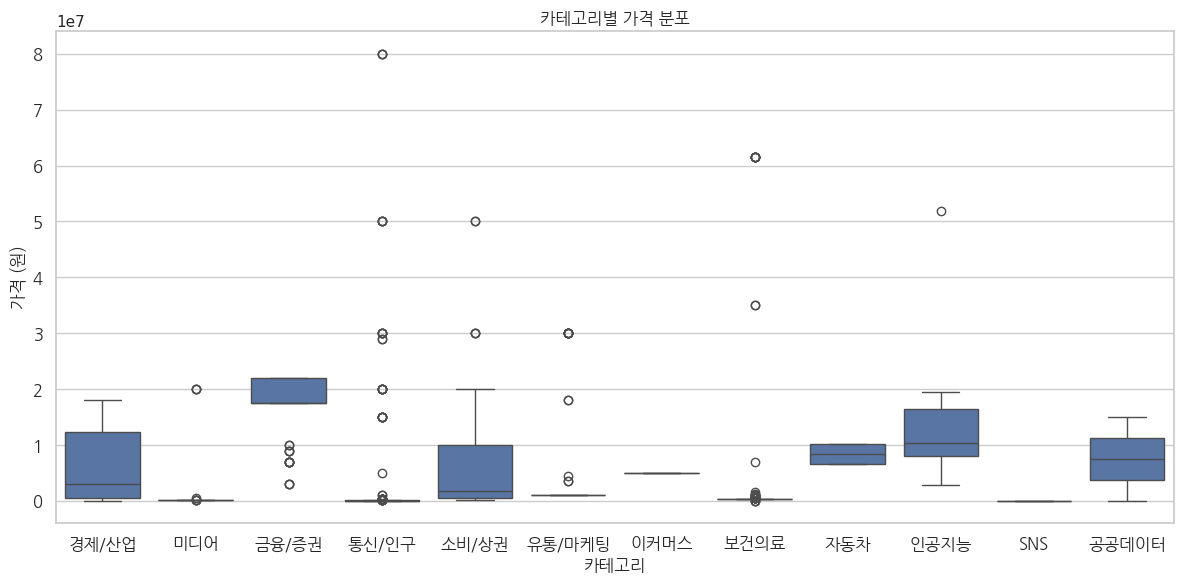

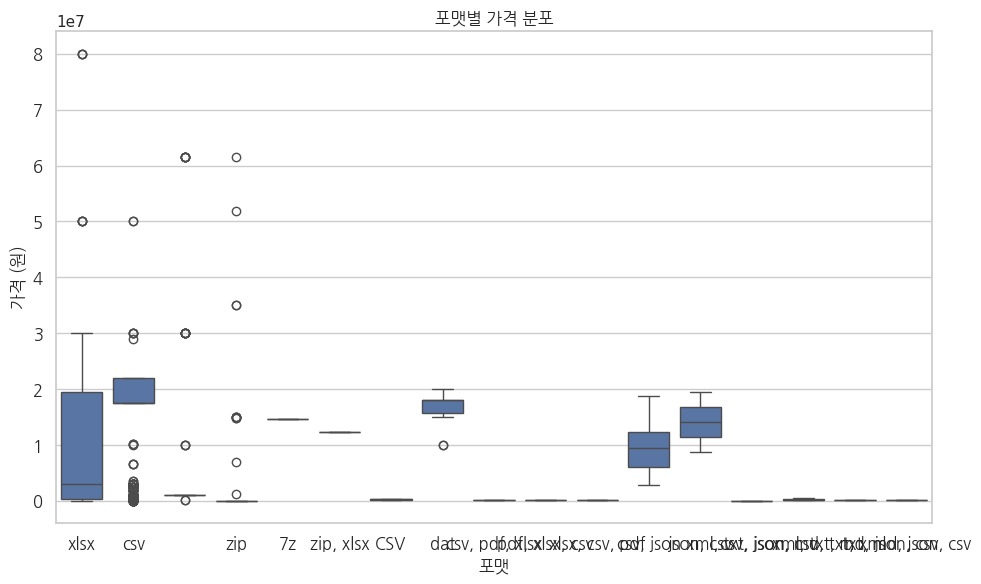

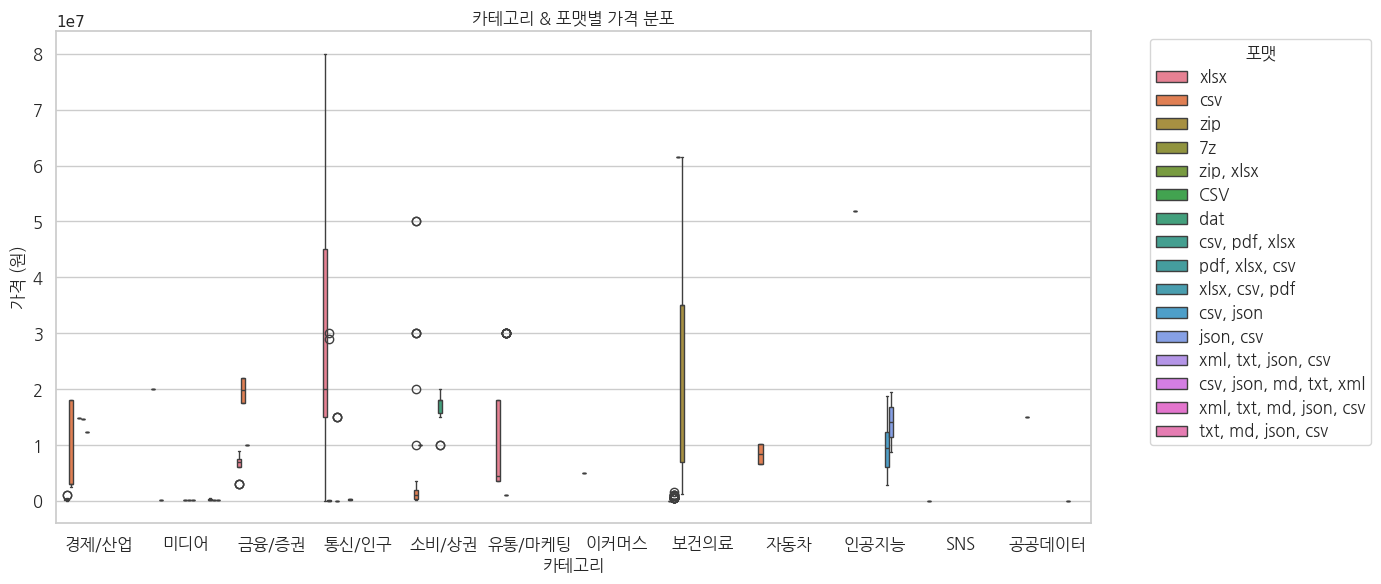

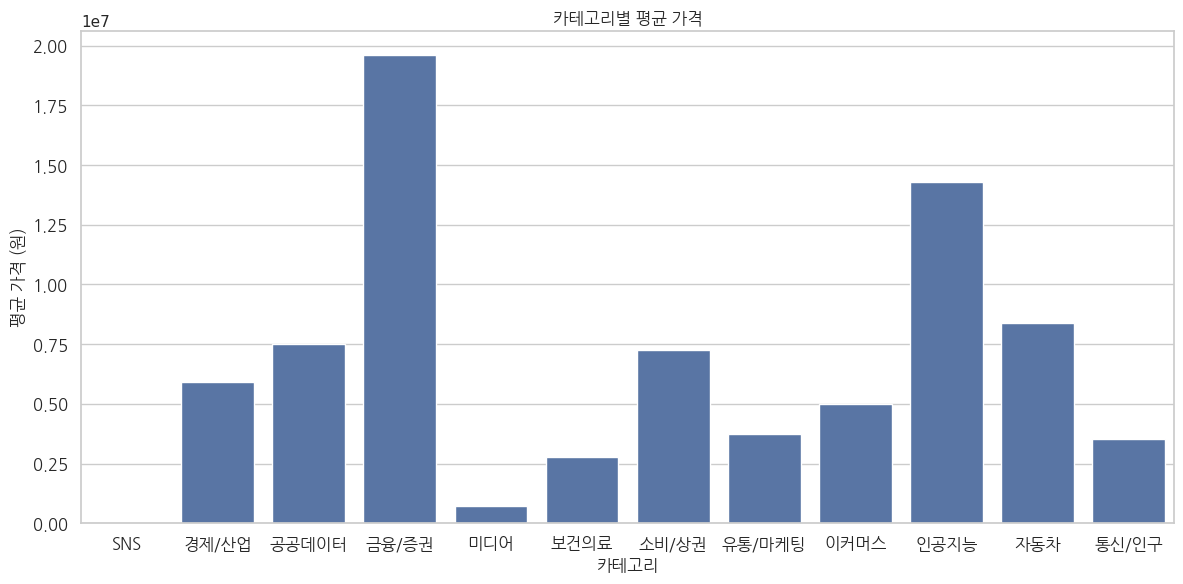

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import json

# ✅ 한글 폰트 개별 지정 객체 생성
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
prop = fm.FontProperties(fname=font_path)

# ✅ 구글 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

# ✅ JSONL 파일 경로
file_path = '/content/drive/MyDrive/00. 대학원/data-price-20250706-v2.jsonl'

# ✅ JSONL 파일 읽기
records = []
with open(file_path, 'r', encoding='utf-8') as f:
    for line in f:
        line = line.strip()
        if line:
            records.append(json.loads(line))

# ✅ DataFrame 변환
df = pd.DataFrame(records)

# ✅ price_num을 숫자로 변환 (문자열 등 오류 시 NaN)
df['price_num'] = pd.to_numeric(df['price_num'], errors='coerce')

# ✅ NaN 제외
df = df.dropna(subset=['price_num'])

# ✅ 가격이 0이거나 협의인 경우는 제외 (선택)
df_filtered = df[(df['price_num'] > 0) & (df['price_type'] == '고정')]

# ✅ seaborn 스타일 설정
sns.set(style="whitegrid")

# ✅ 카테고리별 가격 분포 boxplot
plt.figure(figsize=(12, 6))
ax1 = sns.boxplot(x='category', y='price_num', data=df_filtered)
ax1.set_title('카테고리별 가격 분포', fontproperties=prop)
ax1.set_ylabel('가격 (원)', fontproperties=prop)
ax1.set_xlabel('카테고리', fontproperties=prop)
for label in ax1.get_xticklabels():
    label.set_fontproperties(prop)
for label in ax1.get_yticklabels():
    label.set_fontproperties(prop)
plt.tight_layout()
plt.show()

# ✅ 포맷별 가격 분포 boxplot
plt.figure(figsize=(10, 6))
ax2 = sns.boxplot(x='format', y='price_num', data=df_filtered)
ax2.set_title('포맷별 가격 분포', fontproperties=prop)
ax2.set_ylabel('가격 (원)', fontproperties=prop)
ax2.set_xlabel('포맷', fontproperties=prop)
for label in ax2.get_xticklabels():
    label.set_fontproperties(prop)
for label in ax2.get_yticklabels():
    label.set_fontproperties(prop)
plt.tight_layout()
plt.show()

# ✅ 카테고리 & 포맷 조합별 가격 분포 boxplot
plt.figure(figsize=(14, 6))
ax3 = sns.boxplot(x='category', y='price_num', hue='format', data=df_filtered)
ax3.set_title('카테고리 & 포맷별 가격 분포', fontproperties=prop)
ax3.set_ylabel('가격 (원)', fontproperties=prop)
ax3.set_xlabel('카테고리', fontproperties=prop)
for label in ax3.get_xticklabels():
    label.set_fontproperties(prop)
for label in ax3.get_yticklabels():
    label.set_fontproperties(prop)
leg = ax3.legend(title='포맷', bbox_to_anchor=(1.05, 1), loc='upper left')
leg.set_title('포맷', prop=prop)
for text in leg.get_texts():
    text.set_fontproperties(prop)
plt.tight_layout()
plt.show()

# ✅ 카테고리별 평균 가격 barplot (참고용)
plt.figure(figsize=(12, 6))
avg_prices = df_filtered.groupby('category')['price_num'].mean().reset_index()
ax4 = sns.barplot(x='category', y='price_num', data=avg_prices)
ax4.set_title('카테고리별 평균 가격', fontproperties=prop)
ax4.set_ylabel('평균 가격 (원)', fontproperties=prop)
ax4.set_xlabel('카테고리', fontproperties=prop)
for label in ax4.get_xticklabels():
    label.set_fontproperties(prop)
for label in ax4.get_yticklabels():
    label.set_fontproperties(prop)
plt.tight_layout()
plt.show()
